In [1]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import gseapy
from gseapy.plot import barplot, dotplot
import networkx as nx
import OmicsIntegrator as oi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats
import community 
import pickle
import itertools
from upsetplot import from_contents, UpSet
from mne_connectivity.viz import plot_connectivity_circle
from tqdm import tqdm
import time
import random
import json

import get_binarized_map_of_selected_loci_5 as diff

In [2]:
# Reload modules in case of modifications
reload(diff)

<module 'get_binarized_map_of_selected_loci_5' from '/home/braunger/masterthesis/python_code/compare_hic/get_binarized_map_of_selected_loci_5.py'>

In [3]:
data_dir = '/home/braunger/masterthesis/data/'
save_dir = '/home/braunger/masterthesis/save/'
hic_dir = save_dir + 'processed_hic_data/'
las_dir = '/home/braunger/rejuvenation_project/data/processed_hic_data/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'

# 1. Binarized maps and difference matrix

In [4]:
young = pd.read_csv(hic_dir+'Young_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)
old = pd.read_csv(hic_dir+'Old_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)

# Differences between young and old
diff_map = young + 2 * old #0: no intermingling, 1: young-specific, 2: old-specific, 3: shared intermingling
print(diff_map.shape)
diff_map.to_csv(hic_dir+'difference_maps/diff_all_gene_loci.csv')

(5399, 5399)


In [ ]:
%matplotlib inline
diff.plot_binarized_maps(young, old, diff_map, filtering = False)
plt.savefig(fig_dir+'diff_map_all_loci', dpi = 500)

In [ ]:
%matplotlib inline
diff.plot_binarized_maps_chr_pair(young, old, diff_map, chr_pair = (17, 19))
plt.savefig(fig_dir+'diff_map_chr17_19', dpi = 500)

In [5]:
# How strongly do the interactions overlap
def get_intra(df):
    df['loc1'] = df.index
    df = pd.melt(df, id_vars = 'loc1', var_name = 'loc2')
    df = df[df['value'] != 0]
    df['chr1'] = df['loc1'].str.split('_').str[1]
    df['chr2'] = df['loc2'].str.split('_').str[1]
    df = df[df['chr1'] == df['chr2']]
    interactions = [df.iloc[ix, 0] + "-" + df.iloc[ix, 1] for ix in range(0, df.shape[0])]
    return interactions

def get_inter(df):
    df['loc1'] = df.index
    df = pd.melt(df, id_vars = 'loc1', var_name = 'loc2')
    df = df[df['value'] != 0]
    df['chr1'] = df['loc1'].str.split('_').str[1]
    df['chr2'] = df['loc2'].str.split('_').str[1]
    df = df[df['chr1'] != df['chr2']]
    interactions = [df.iloc[ix, 0] + "-" + df.iloc[ix, 1] for ix in range(0, df.shape[0])]
    return interactions

# UpSet plot for intrachromosomal contacts
intersections = from_contents({'Old': get_intra(old), 
                               'Young': get_intra(young)})
upset = UpSet(intersections, subset_size='count', show_percentages = True,
             sort_by="cardinality", sort_categories_by=None).plot()
plt.figtext(0.45, 0.95, 'Intrachromosomal LAS')
plt.savefig(fig_dir + 'intra_LAS_intersections.png', dpi = 500, bbox_inches="tight")
plt.show()

# UpSet plot for interchromosomal contacts
intersections = from_contents({'Old': get_inter(old),
                               'Young': get_inter(young)})
upset = UpSet(intersections, subset_size='count', show_percentages = True,  
              sort_by="cardinality", sort_categories_by=None).plot()
plt.figtext(0.45, 0.95, 'Interchromosomal LAS')
plt.savefig(fig_dir + 'inter_LAS_intersections.png', dpi = 500, bbox_inches="tight")
plt.show()

# 2. Number of intermingling regions per chromosome pair

In [6]:
chr_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
fig, axs = plt.subplots(1, 3, figsize = (18, 5))
diff.plot_specific_intermingling(chr_list, diff_map, "Young", axs[0])
diff.plot_specific_intermingling(chr_list, diff_map, "Old", axs[1])
diff.plot_intermingling_diff(chr_list, diff_map, "Young", "Old", axs[2], -1000, 1000)
plt.savefig(fig_dir + 'specific_intermingling_per_chr_pair.png', dpi = 500, bbox_inches="tight")
plt.show()

In [16]:
# Total number of interchromosomal LAS submatrices
young_B1R1 = diff.LAS_statistics(chr_list, las_dir, 'Young_B1R1', 20)
print('Young replicate 1: ', int(young_B1R1['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_B1R1['LAS'].sum()), ' submatrices')
young_B1R2 = diff.LAS_statistics(chr_list, las_dir, 'Young_B1R2', 20)
print('Young replicate 2: ', int(young_B1R2['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_B1R2['LAS'].sum()), ' submatrices')
old_B1R1 = diff.LAS_statistics(chr_list, las_dir, 'Old_B1R1', 20)
print('Old replicate 1: ', int(old_B1R1['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_B1R1['LAS'].sum()), ' submatrices')
old_B2R2 = diff.LAS_statistics(chr_list, las_dir, 'Old_B2R2', 20)
print('Old replicate 2: ', int(old_B2R2['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_B2R2['LAS'].sum()), ' submatrices')

Young replicate 1:  888654  intermingling regions  and  1162  submatrices
Young replicate 2:  936314  intermingling regions  and  1177  submatrices
Old replicate 1:  861632  intermingling regions  and  1013  submatrices
Old replicate 2:  1193155  intermingling regions  and  1325  submatrices


In [18]:
# Total number of intrachromosomal LAS submatrices
young_B1R1 = diff.LAS_statistics(chr_list, las_dir, 'Young_B1R1', 'intra-5')
print('Young replicate 1: ', int(young_B1R1['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_B1R1['LAS'].sum()), ' submatrices')
young_B1R2 = diff.LAS_statistics(chr_list, las_dir, 'Young_B1R2', 'intra-5')
print('Young replicate 2: ', int(young_B1R2['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_B1R2['LAS'].sum()), ' submatrices')
old_B1R1 = diff.LAS_statistics(chr_list, las_dir, 'Old_B1R1', 'intra-5')
print('Old replicate 1: ', int(old_B1R1['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_B1R1['LAS'].sum()), ' submatrices')
old_B2R2 = diff.LAS_statistics(chr_list, las_dir, 'Old_B2R2', 'intra-5')
print('Old replicate 2: ', int(old_B2R2['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_B2R2['LAS'].sum()), ' submatrices')

Young replicate 1:  1480875  intermingling regions  and  1972  submatrices
Young replicate 2:  1578772  intermingling regions  and  1984  submatrices
Old replicate 1:  1647161  intermingling regions  and  1738  submatrices
Old replicate 2:  1664599  intermingling regions  and  1694  submatrices


# 3. Difference maps
## a) For all DE targets in one transition

(131, 5)
(131, 5)
(124, 124)


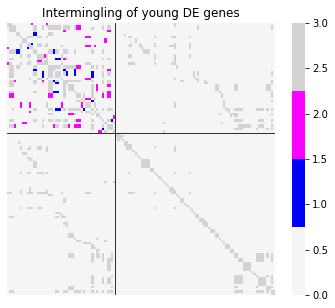

In [270]:
# Upregulated targets in S1
DE_diff_map = diff.get_diff_map_DE(diff_map, 'fc_16-26_27-60', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
    
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'fc_16-26_27-60', 'young', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_young_DE.png', dpi = 500, bbox_inches="tight")

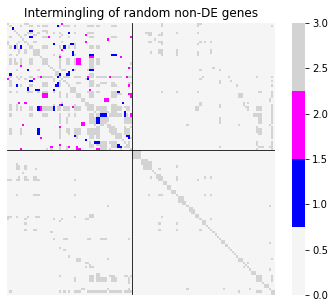

In [272]:
# Comparison to random non-DE genes
diff.plot_diff_map_non_DE(diff_map,'fc_16-26_27-60', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_non_DE_young.png', dpi = 500, bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [50:58<00:00,  3.06s/it]


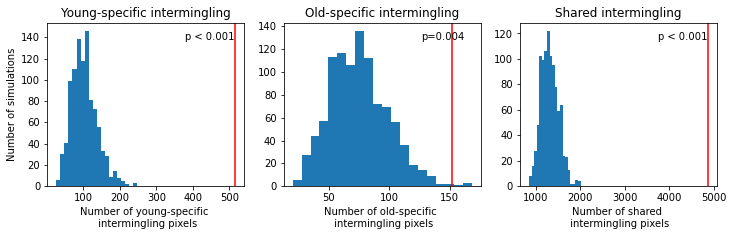

In [304]:
diff.quantify_im_changes(diff_map, 'fc_16-26_27-60', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'hist_im_types_young.png', dpi = 500, bbox_inches="tight")

(162, 5)
(162, 5)
(157, 157)


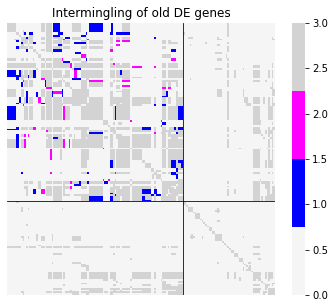

In [273]:
# Downregulated targets in S3
DE_diff_map = diff.get_diff_map_DE(diff_map, 'fc_61-85_86-96', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)

# Plot intermingling difference map
diff.diff_map_DE(diff_map, 'fc_61-85_86-96', 'old', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_old_DE.png', dpi = 500, bbox_inches="tight")

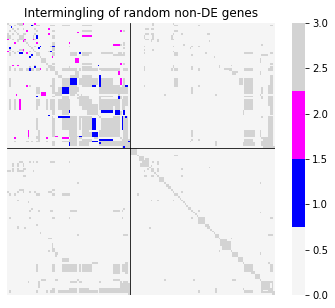

In [274]:
diff.plot_diff_map_non_DE(diff_map,'fc_61-85_86-96', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_non_DE_old.png', dpi = 500, bbox_inches="tight")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:01:42<00:00,  3.70s/it]


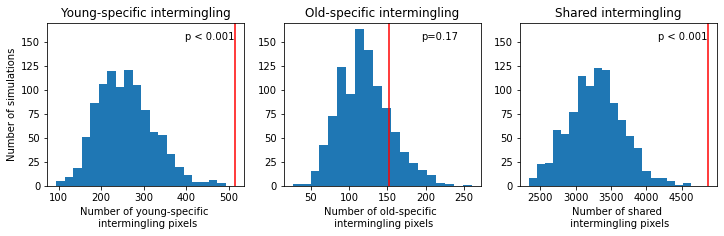

In [411]:
diff.quantify_im_changes(diff_map, 'fc_61-85_86-96', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'hist_im_types_old.png', dpi = 500, bbox_inches="tight")

(131, 5)


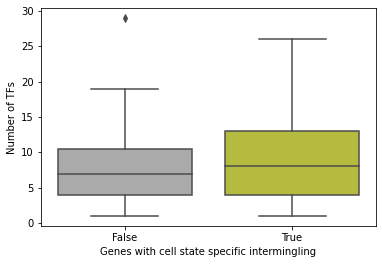

In [8]:
# by how many TFs is each gene targeted?
DE_diff_map_young = diff.get_diff_map_DE(diff_map, 'fc_16-26_27-60', data_dir, save_dir)
intermingling_genes = DE_diff_map_young.columns[(DE_diff_map_young.isin([1, 2])).any(axis=1)].tolist()
TF_groups = pd.read_csv(save_dir+'pcst/incl_TFs_design2.csv')

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
DE_genes = pd.read_csv(save_dir + 'DE_genes/DE_updown.csv')
DE_genes = DE_genes[DE_genes['transition'] == 'fc_16-26_27-60']
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[TF_targets['TF'].isin(TF_groups.loc[TF_groups['net'].isin(['young_net', 'shared']), 'TF'])]

target_counts = TF_targets.groupby('target')['target'].count()
target_counts = pd.DataFrame({'target': target_counts.index, 
                              'n_TFs': target_counts.values, 
                              'intermingling': 'False'})
target_counts.loc[target_counts['target'].isin(intermingling_genes), 'intermingling'] = 'True'
target_counts.to_csv(save_dir+'DE_genes/n_TFs_per_young_DE_gene.csv', index = False)

plt.figure()
my_pal = {"False": "#aaaaaa", "True": "#c6d02a"}
sns.boxplot(data=target_counts, x='intermingling', y='n_TFs', palette = my_pal) 
plt.ylabel('Number of TFs')
plt.xlabel('Genes with cell state specific intermingling')
plt.savefig(fig_dir + 'n_TFs_young_DE.png')
plt.show()

(162, 5)


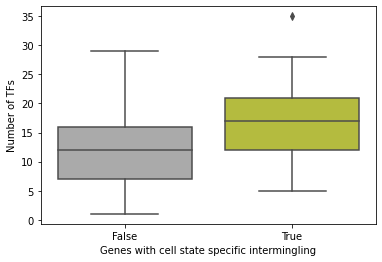

In [9]:
DE_diff_map_old = diff.get_diff_map_DE(diff_map, 'fc_61-85_86-96', data_dir, save_dir)
intermingling_genes = DE_diff_map_old.columns[(DE_diff_map_old.isin([1, 2])).any(axis=1)].tolist()
TF_groups = pd.read_csv(save_dir+'pcst/incl_TFs_design2.csv')

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
DE_genes = pd.read_csv(save_dir + 'DE_genes/DE_updown.csv')
DE_genes = DE_genes[DE_genes['transition'] == 'fc_61-85_86-96']
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[TF_targets['TF'].isin(TF_groups.loc[TF_groups['net'].isin(['old_net', 'shared']), 'TF'])]

target_counts = TF_targets.groupby('target')['target'].count()
target_counts = pd.DataFrame({'target': target_counts.index, 
                              'n_TFs': target_counts.values, 
                              'intermingling': 'False'})
target_counts.loc[target_counts['target'].isin(intermingling_genes), 'intermingling'] = 'True'
target_counts.to_csv(save_dir+'DE_genes/n_TFs_per_old_DE_gene.csv', index = False)

plt.figure()
sns.boxplot(data=target_counts, x='intermingling', y='n_TFs', palette = my_pal) 
plt.ylabel('Number of TFs')
plt.xlabel('Genes with cell state specific intermingling')
plt.savefig(fig_dir + 'n_TFs_old_DE.png')
plt.show()

In [927]:
# Create bipartite graph of intermingling genes and its TFs
TF_targets = TF_targets[TF_targets['target'].isin(intermingling_genes)]
# load all TF groups
TF_groups = pd.read_csv(save_dir+'pcst/incl_TFs_design2.csv')
young_TFs = set(TF_groups.loc[TF_groups['net'] == 'young_net', 'TF'])
middle_TFs = set(TF_groups.loc[TF_groups['net'] == 'middle_net', 'TF'])
old_TFs = set(TF_groups.loc[TF_groups['net'] == 'old_net', 'TF'])
TF_targets = TF_targets[TF_targets['TF'].isin(young_TFs)]

network = nx.from_pandas_edgelist(TF_targets, 'TF', 'target')

# node attributes for TFs and targets
anno_dict = {}
for target in TF_targets['target'].unique():
    anno_dict[target] = 'targets'
for TF in TF_targets['TF'].unique():
    anno_dict[TF] = 'TFs'
nx.set_node_attributes(network, anno_dict, name='TF-targets')

# normalized degree per node
all_tf_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
degrees = {}
for TF in anno_dict.keys():
    targets_total = all_tf_targets[all_tf_targets['TF'] == TF]
    if targets_total.shape[0] == 0: 
        continue
    #print(targets_total)
    intermingling_DE_targets = TF_targets[TF_targets['TF'] == TF]
    #print(intermingling_DE_targets)
    if intermingling_DE_targets.shape[0] == 0: 
        continue
    degrees[TF] = (intermingling_DE_targets.shape[0] / targets_total.shape[0]) * 100 
nx.set_node_attributes(network, degrees, name='percentage DE targets')

# save resulting network
oi.output_networkx_graph_as_interactive_html(network, filename=save_dir + "TF_targets_intermingling_young.html")

PosixPath('/home/braunger/masterthesis/save/TF_targets_intermingling_young.html')

<AxesSubplot:xlabel='target2'>

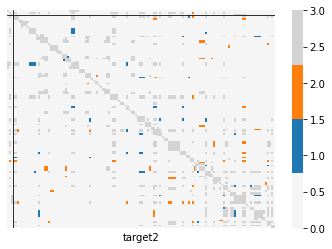

In [249]:
diff.diff_map_updown(TF_diff_map, gene_order, transition, save_dir + 'DE_genes/')

In [15]:
# save diff map for all upregulated young DE genes
# Load differentially expressed genes
DE_genes = pd.read_csv(save_dir + 'DE_genes/DE_updown.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]
DE_genes = DE_genes[DE_genes['updown'] == "up"]
diff_map_up = TF_diff_map.loc[TF_diff_map.columns.isin(DE_genes['gene']), TF_diff_map.columns.isin(DE_genes['gene'])]
diff_map_up.to_csv(save_dir + 'processed_hic_data/difference_maps/diff_DE_up_young.csv', index = False)


## b) For DE targets of one TF in one transition

(5, 2)


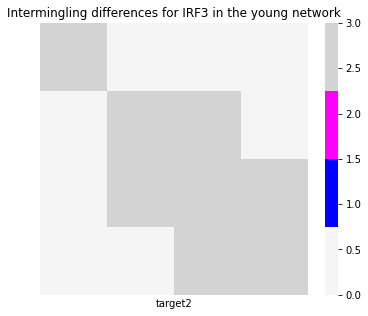

In [6]:
diff.diff_map_TF_transition(diff_map, 'IRF3', 'fc_16-26_27-60', 'young', data_dir, save_dir)

(52, 2)


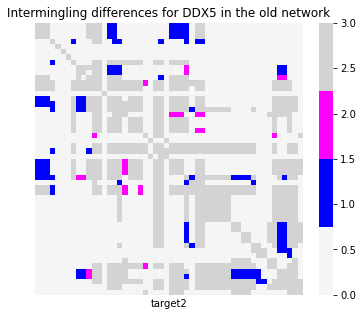

In [14]:
diff.diff_map_TF_transition(diff_map, 'DDX5', 'fc_61-85_86-96', 'old', data_dir, save_dir)

(162, 5)


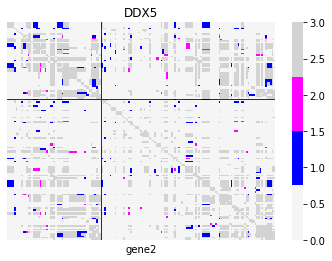

In [15]:
diff.diff_map_TF(diff_map, "DDX5", 'fc_61-85_86-96', 'old', data_dir, save_dir)

In [12]:
# quantify amount of intermingling between the DE targets of each TF
net = 'old'
if net == "young": 
    transition = "fc_16-26_27-60"
elif net == "old": 
    transition = "fc_61-85_86-96"

# Select TFs identified in the network of interest
TF_list = TF_groups.loc[TF_groups['net'] == net + '_net', 'TF']
# Load DE genes for the selected transition
DE_diff_map = diff.get_diff_map_DE(diff_map, transition, data_dir, save_dir)

spec_intermingling = pd.DataFrame({'TF': [], 'spec_intermingling': [], 'shared_intermingling': []})
for TF in TF_list:
    
    # load DE targets of selected TF
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    TF_targets = TF_targets[TF_targets['target'].isin(DE_diff_map.columns)]
    
    # calculate percentages of cell-state specific and shared intermingling
    TF_diff_long = DE_diff_map.loc[TF_targets['target'], TF_targets['target']]
    TF_diff_long['loc1'] = TF_diff_long.index
    TF_diff_long = TF_diff_long.melt(id_vars = 'loc1', var_name = 'loc2')
    count_spec_im = TF_diff_long['value'].isin([1,2]).sum() / TF_diff_long.shape[0]
    count_shared_im = TF_diff_long['value'].isin([3]).sum() / TF_diff_long.shape[0]
    spec_intermingling = pd.concat([spec_intermingling, 
                                   pd.DataFrame({'TF': [TF], 
                                                'spec_intermingling': count_spec_im, 
                                                'shared_intermingling': count_shared_im})], 
                                   ignore_index = True)
     
spec_intermingling.to_csv(hic_dir + 'spec_intermingling_' + net + '.csv', index = False)    
print(spec_intermingling.head())

(162, 5)


/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


      TF  spec_intermingling  shared_intermingling
0   NFIC            0.041649              0.287797
1    SRC            0.043367              0.339286
2  GTF2B            0.026045              0.163621
3  HDAC6                 NaN                   NaN
4   TAF3            0.048414              0.270032


In [11]:
spec_intermingling[spec_intermingling['TF'] == 'IRF3']

,TF,spec_intermingling,shared_intermingling
27,IRF3,0.0,0.555556


## c) For yound and old DE targets of one TF

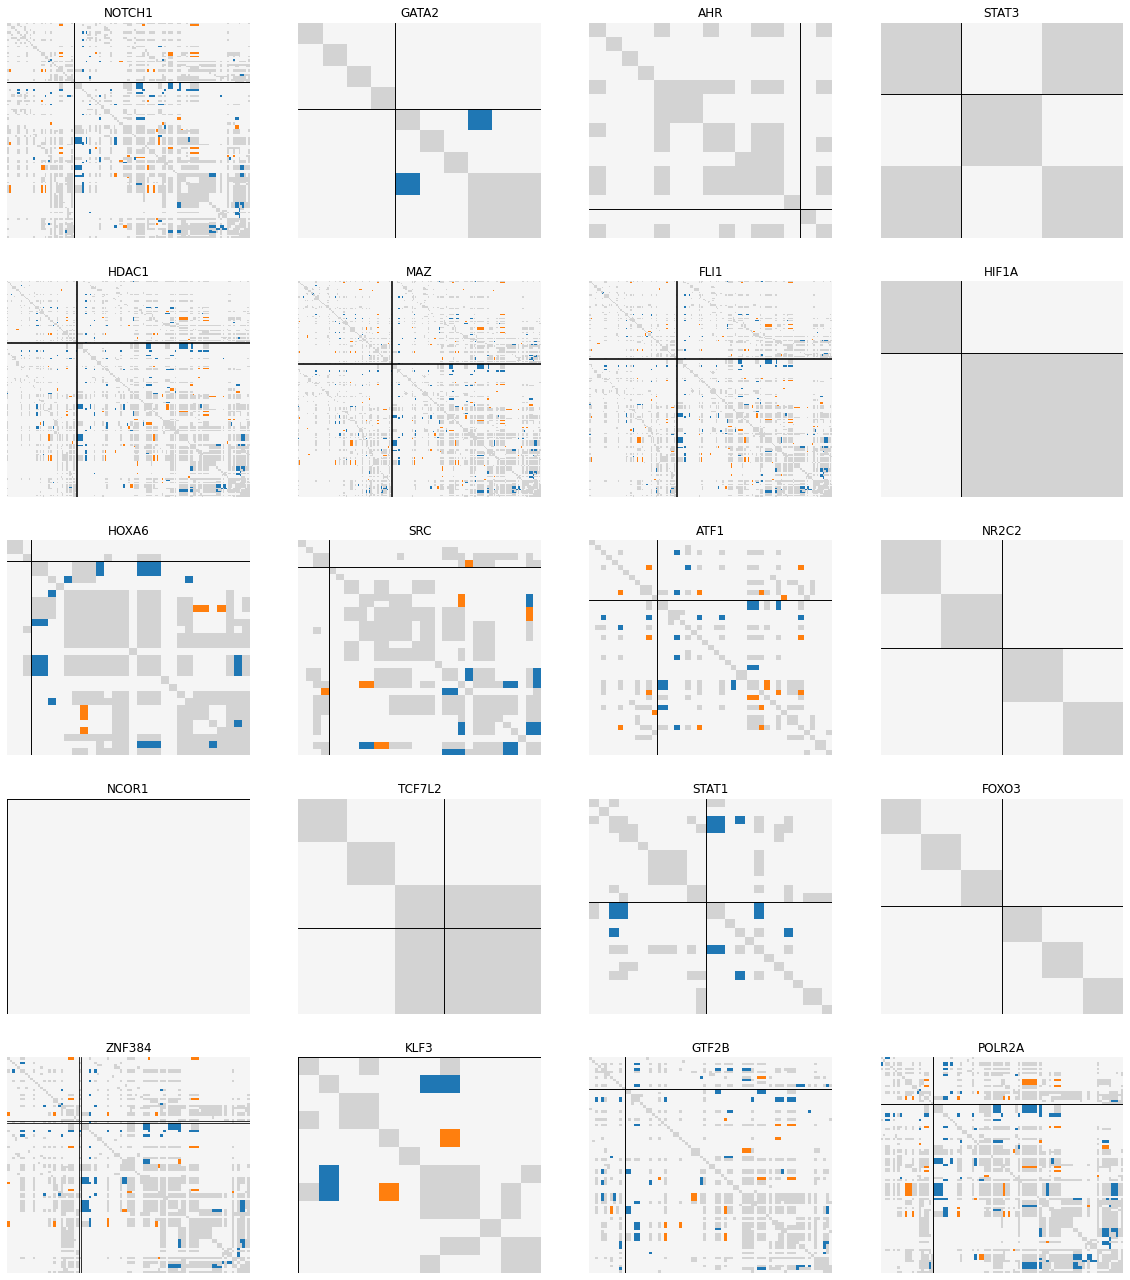

In [273]:
# load all shared TFs
shared_TFs = list(young_TFs.intersection(middle_TFs.intersection(old_TFs)))

# plot intermingling of young and old DE targets for all shared TFs
fig, axs = plt.subplots(5, 4, figsize = (20, 23))
counter = 0
for ax in axs.flat:
    diff.diff_map_young_old(diff_map, shared_TFs[counter], data_dir, save_dir, ax)
    counter += 1
plt.savefig(fig_dir + 'intermingling_all_shared_TFs.png')
plt.show()

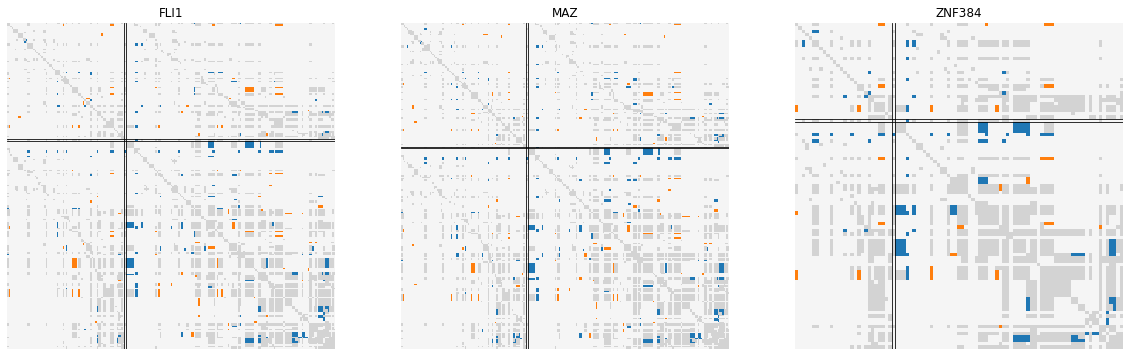

In [278]:
# same plot only for MAZ, FLI1, ZNF384
TFs = ['FLI1', 'MAZ', 'ZNF384']

# plot intermingling of young and old DE targets for all shared TFs
fig, axs = plt.subplots(1, 3, figsize = (20, 6))
counter = 0
for ax in axs.flat:
    diff.diff_map_young_old(diff_map, TFs[counter], data_dir, save_dir, ax)
    counter += 1
plt.savefig(fig_dir + 'intermingling_FLI1_MAZ_ZNF384.png')
plt.show()

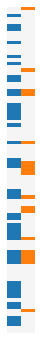

In [371]:
# annotation bars
TF = 'ZNF384'
diff_yo = diff.diff_map_young_old(diff_map, TF, data_dir, save_dir, axs, return_data = True)
# young intermingling annotation
diff_yo['y_intermingling'] =  0
diff_yo.loc[(diff_yo==1).any(axis=1),'y_intermingling'] = 1
# old intermingling annotation
diff_yo['o_intermingling'] =  0
diff_yo.loc[(diff_yo==2).any(axis=1),'o_intermingling'] = 2
anno_yo = diff_yo[['y_intermingling', 'o_intermingling']]

plt.figure(figsize = (0.5, 6))
palette = sns.color_palette("tab10")
colors = ['whitesmoke', palette[0], palette[1]]
cmap = ListedColormap(colors)
sns.heatmap(anno_yo, cmap = cmap, cbar = False)
plt.axis('off')
plt.show()

In [501]:
# percentage of young and old specific intermingling in the diff map of a given TF
TF = "FLI1"
TF_diff_map = diff.diff_map_young_old(diff_map, TF, data_dir, save_dir, axs, return_data = True)
young_specific = np.count_nonzero(TF_diff_map.to_numpy() == 1) / (TF_diff_map.shape[0] * TF_diff_map.shape[0]) *100
old_specific = np.count_nonzero(TF_diff_map.to_numpy() == 2) / (TF_diff_map.shape[0] * TF_diff_map.shape[0]) *100
print('Percent of young-specific intermingling: ', young_specific)
print('Percent of old-specific intermingling: ', old_specific)

Percent of young-specific intermingling:  1.1329321783596729
Percent of old-specific intermingling:  0.5598536445590602


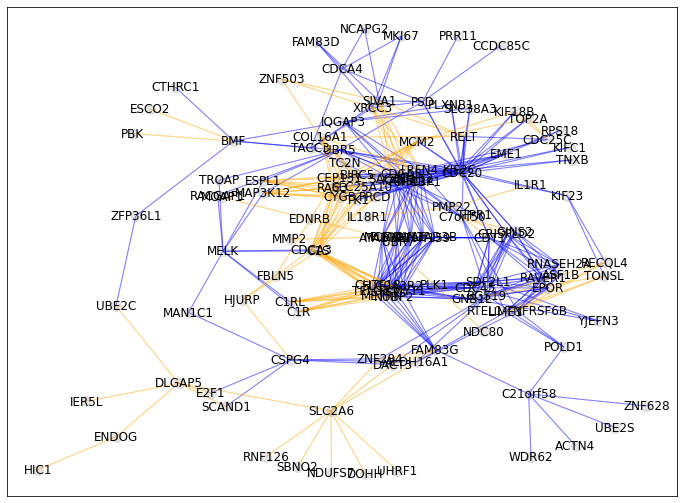

In [705]:
TF = 'FLI1'
diff_map_long = diff.diff_map_young_old(diff_map, TF, data_dir, save_dir, axs, return_data = True)
diff_map_long['target1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'target1', var_name = 'target2')
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])
diff_map_long = diff_map_long[diff_map_long['value'] != 'shared']
#diff_map_long.to_csv(hic_dir+'difference_maps/diff_map_' + TF + '.csv', index = False)

network = nx.from_pandas_edgelist(diff_map_long, 'target1', 'target2', 'value')

plt.figure(figsize = (12,9))
# Draw
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)
# Draw terminals 
nx.draw_networkx_nodes(network, 
                       pos,
                       node_color= 'grey', 
                       node_size=100,
                       node_shape='o',
                       alpha=0.2)
# Draw edges
# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=1.0, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=1.0, 
                       alpha=0.3, 
                       edge_color='orange')

# Draw labels
nx.draw_networkx_labels(network,
                        pos,
                        font_size=12)
#nx.draw_networkx_labels(network,
#                        pos,
#                        labels = {"DLGAP5": "DLGAP5", "CDC45": "CDC45", "TOP2A": "TOP2A"},
#                        font_color = "red",
#                        font_size=12)
ax.axis('off')
plt.show()

In [504]:
yo_counts = diff_map_long.groupby(['target1', 'value']).count()
yo_counts = yo_counts.reset_index(level=['value'])
yo_counts = pd.pivot(yo_counts, columns= 'value', values= 'target2').fillna(0)
yo_counts['sum'] = yo_counts['old'] + yo_counts['young']
yo_counts['y_percent'] = yo_counts['young'] / yo_counts['sum'] * 100
yo_counts['o_percent'] = yo_counts['old'] / yo_counts['sum'] * 100
yo_counts = yo_counts.sort_values(by = ['y_percent', 'young'], ascending = False)
yo_counts.head()

value,old,young,sum,y_percent,o_percent
target1,,,,,
CDC20,0.0,24.0,24.0,100.0,0.0
KIF2C,0.0,24.0,24.0,100.0,0.0
SDF2L1,0.0,14.0,14.0,100.0,0.0
CDC45,0.0,12.0,12.0,100.0,0.0
GNB1L,0.0,12.0,12.0,100.0,0.0


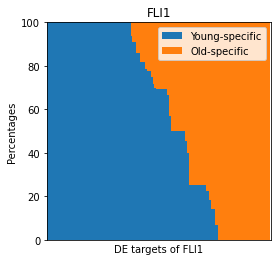

In [435]:
# plot purity of only young or old interactions
fig, ax = plt.subplots(figsize = (4,4))
x_pos = [i for i in range(yo_counts.shape[0])]
ax.bar(x_pos, yo_counts['y_percent'], label='Young-specific', width = 1)
ax.bar(x_pos, yo_counts['o_percent'], bottom=yo_counts['y_percent'], label='Old-specific', width = 1)

ax.set_ylabel('Percentages')
ax.set_xlabel('DE targets of '+TF)
ax.set_title(TF)
ax.legend()

ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.xlim([0,yo_counts.shape[0]])

plt.show()

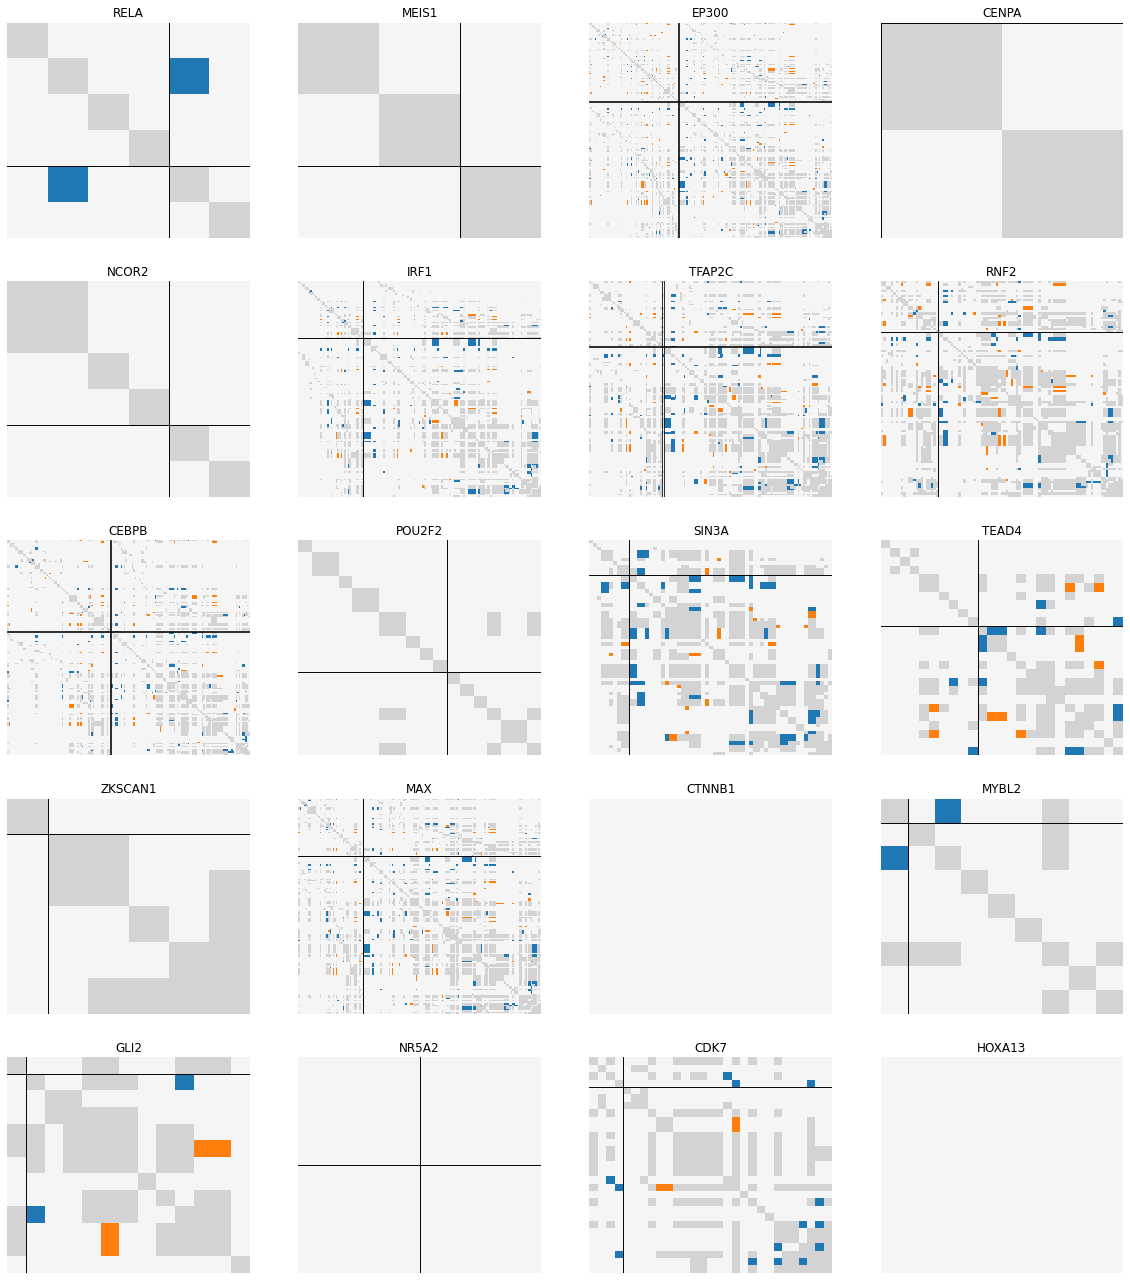

In [275]:
# for young specific TFs
TFs = list(young_TFs.difference(middle_TFs.union(old_TFs)))

# plot intermingling of young and old DE targets for all young specific TFs
fig, axs = plt.subplots(5, 4, figsize = (20, 23))
counter = 0
for ax in axs.flat:
    diff.diff_map_young_old(diff_map, TFs[counter], data_dir, save_dir, ax)
    counter += 1
plt.savefig(fig_dir + 'intermingling_all_young_TFs.png')
plt.show()

(32, 2)


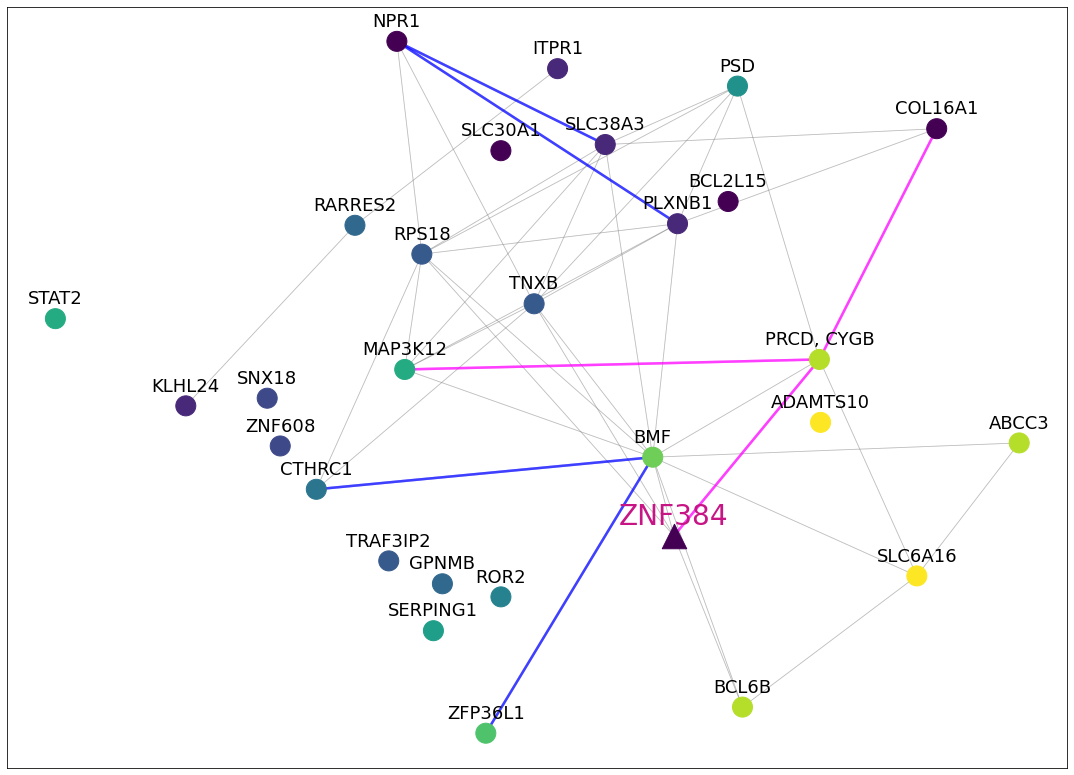

In [236]:
# Create network for young TFs
TF = 'ZNF384'

# get diff map for young DE target genes and TF
TF_diff_map = diff.get_diff_map_TF_transition(diff_map, TF, "fc_16-26_27-60", data_dir, save_dir)

# transform to long format and filter for specific intermingling
diff_map_long = TF_diff_map.copy()
diff_map_long['target1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'target1', var_name = 'target2')
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])
#diff_map_long = diff_map_long[diff_map_long['value'] != 'shared']

# get genomic location of each gene
gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
gene_loci = gene_loci[gene_loci['gene'].isin(TF_diff_map.columns)]
gene_loci[['chr','chr_number', 'loc', 'loc_number']]=gene_loci.locus.str.split('_',expand=True)

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'target1', 'target2', 'value')

# draw network
plt.figure(figsize = (19,14))
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)
pos['ZNF384'] = np.array([2.6, -4.1])
pos['SLC38A3'] = np.array([1.2, 5.8])
pos['SERPING1'] = np.array([-2.3, -6.5])

# Draw terminals 
gene_loci = gene_loci.set_index('gene')
gene_loci = gene_loci.reindex(network.nodes())
gene_loci['chr_number']=pd.Categorical(gene_loci['chr_number'], categories = [str(i) for i in range(1, 23)])  
gene_loci.loc['PRCD, CYGB', 'chr_number'] = '17'

targets = [protein for protein in diff_map_long['target1'].unique() if protein != TF]
 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = targets,
                       node_color= gene_loci.loc[gene_loci.index != TF, 'chr_number'].cat.codes,
                       node_size=400,
                       node_shape='o',
                       alpha=1)

nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = [TF],
                       node_color = gene_loci.loc[gene_loci.index == TF, 'chr_number'].cat.codes,
                       node_size=600,
                       node_shape='^',
                       alpha=1)

# Draw edges
# shared intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'shared'].index]
shared_edges = [(gene1, gene2) for (gene1, gene2) in shared_edges 
                if gene_loci.loc[gene1, 'chr_number'] != gene_loci.loc[gene2, 'chr_number']]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.8, 
                       alpha=0.3, 
                       edge_color='grey')

# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=2.5, 
                       alpha=0.5, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=2.5, 
                       alpha=0.5, 
                       edge_color='magenta')

# Draw labels
labels = {protein: protein for protein in diff_map_long['target1'].unique() if protein != TF}
new_pos = {protein: np.array([x, y + 0.5]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = labels,
                        font_size=18)
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = {TF: TF},
                        font_color = "mediumvioletred",
                        font_size=28)

plt.savefig(fig_dir + 'network_ZNF384.png', dpi = 500, bbox_inches="tight")
plt.show()

In [120]:
gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
gene_loci[gene_loci['gene'] == 'PRCD']

,gene,locus
11491,PRCD,chr_17_loc_76500000


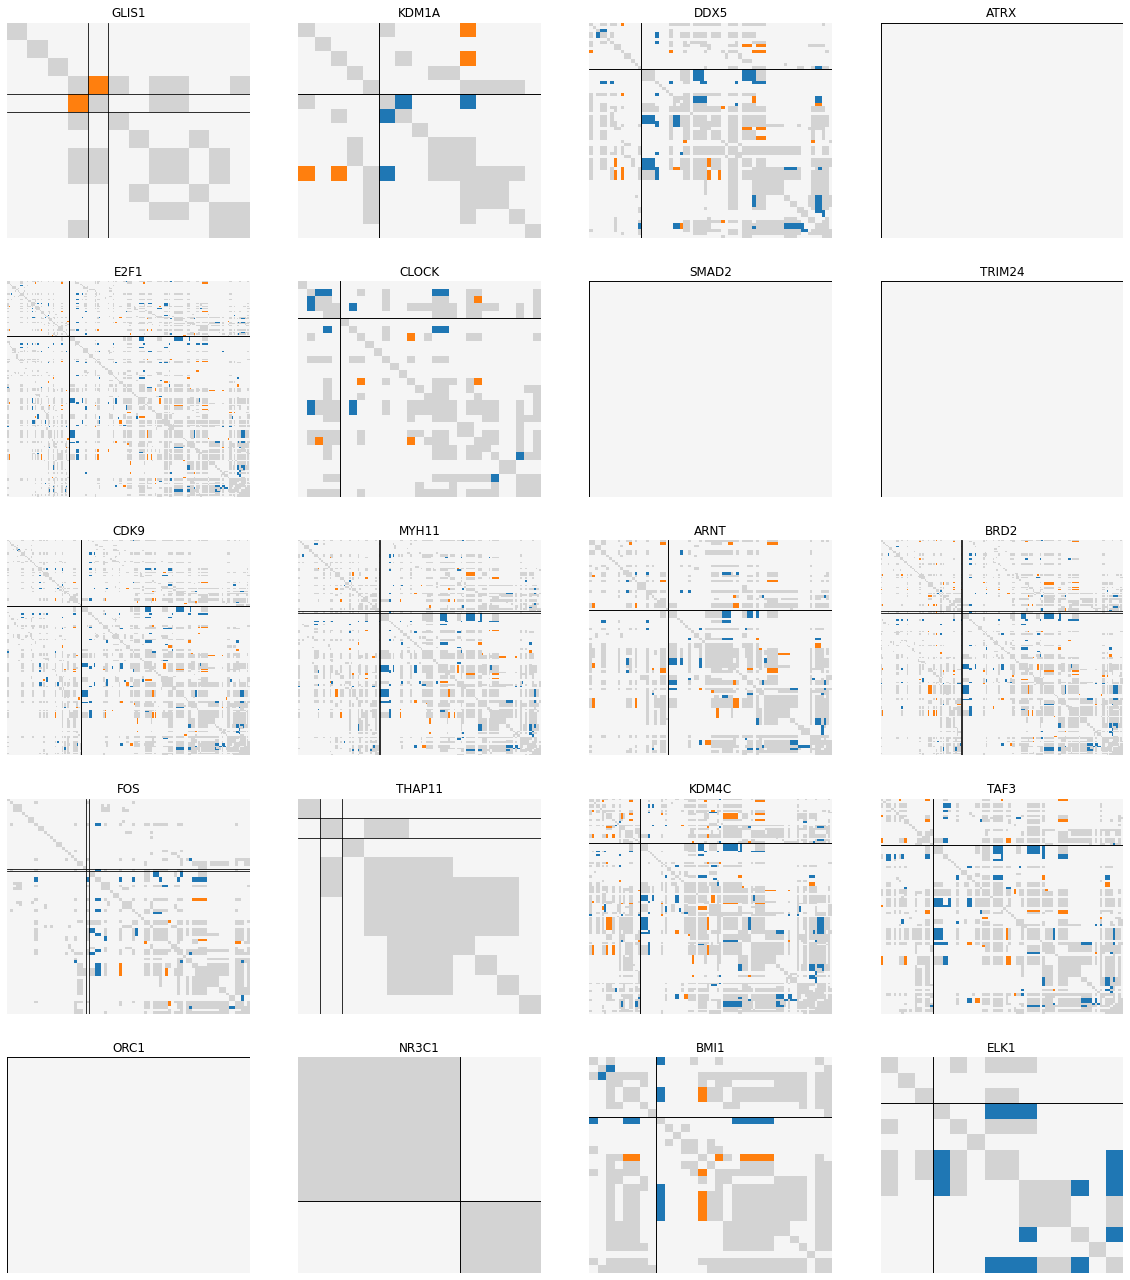

In [276]:
# for old specific TFs
TFs = list(old_TFs.difference(middle_TFs.union(young_TFs)))

# plot intermingling of young and old DE targets for all old specific TFs
fig, axs = plt.subplots(5, 4, figsize = (20, 23))
counter = 0
for ax in axs.flat:
    diff.diff_map_young_old(diff_map, TFs[counter], data_dir, save_dir, ax)
    counter += 1
plt.savefig(fig_dir + 'intermingling_all_old_TFs.png')
plt.show()

In [41]:
# Create network for old TFs
TF = 'FOS'

# get diff map for old DE target genes and TF
TF_diff_map = diff.get_diff_map_TF_transition(diff_map, TF, "fc_61-85_86-96", data_dir, save_dir)

# transform to long format and filter for specific intermingling
diff_map_long = TF_diff_map.copy()
diff_map_long['target1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'target1', var_name = 'target2')
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])
#diff_map_long = diff_map_long[diff_map_long['value'] != 'shared']

# get genomic location of each gene
gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
gene_loci = gene_loci[gene_loci['gene'].isin(TF_diff_map.columns)]
gene_loci[['chr','chr_number', 'loc', 'loc_number']]=gene_loci.locus.str.split('_',expand=True)
# define colors based on the chromosome
chr_palette = pd.DataFrame({'chr_number': [str(i) for i in range(1, 23)],
                           'color': ["#3C723E", "#743F27", "#CD3836", "#F7D24A", "#A7B547", "#76CE97", 
                                     "#B9B9B9", "#F0BFC9", "#434679", "#8CCBEF", "#4397D4", 
                                     "#2C677C", "#7E8180", "#D285DE", "#6F1C16", "#814965", "#FAE1AE", 
                                     "#4299A9", "#E1646B", "#7DE2E7", "#B10DA1", "#C075A6"] })
gene_loci = gene_loci.merge(chr_palette, on = 'chr_number')

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'target1', 'target2', 'value')

# draw network
plt.figure(figsize = (15,15))
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)
pos['PKMYT1'] = np.array([4, 2])
pos['CDC20'] = np.array([4.1, 3.5])
pos['SLC25A10'] = np.array([-1.7,  0])
pos['ESPL1'] = np.array([-1.3,  1.9])

# Draw terminals 
gene_loci = gene_loci.set_index('gene')
gene_loci = gene_loci.reindex(network.nodes())
gene_loci.loc['ZNHIT2, SAC3D1', 'chr_number'] = '11'
gene_loci.loc['ZNHIT2, SAC3D1', 'color'] = "#C4451C"

targets = [protein for protein in diff_map_long['target1'].unique() if protein != TF]

 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = targets,
                       node_color= gene_loci.loc[gene_loci.index != TF, 'color'],
                       node_size=400,
                       node_shape='o',
                       alpha=1)
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = [TF],
                       node_color = gene_loci.loc[gene_loci.index == TF, 'color'],
                       node_size=600,
                       node_shape='^',
                       alpha=1)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'shared'].index]
shared_edges = [(gene1, gene2) for (gene1, gene2) in shared_edges 
                if gene_loci.loc[gene1, 'chr_number'] != gene_loci.loc[gene2, 'chr_number']]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.8, 
                       alpha=0.3, 
                       edge_color='grey')

# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='magenta')

# Draw labels
labels = {protein: protein for protein in diff_map_long['target1'].unique() if protein not in [TF, 'KIF2C', 'CDC20']}
new_pos = {protein: np.array([x, y + 0.25]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = labels,
                        font_size=18)
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = {TF: TF},
                        font_color = gene_loci.loc[gene_loci.index == TF, 'color'].item(),
                        font_size=28)
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = {'KIF2C': 'KIF2C', 'CDC20': 'CDC20'},
                        font_color = gene_loci.loc[gene_loci.index == 'KIF2C', 'color'].item(),
                        font_size=24)

plt.savefig(fig_dir + 'network_FOS.png', dpi = 500, bbox_inches="tight")
plt.show()

(55, 2)


In [42]:
plt.figure(figsize = (0.75, 12))
plt.scatter(x = [2] * chr_palette['chr_number'].shape[0], y = chr_palette['chr_number'], 
            c = chr_palette['color'], s = 150)
plt.xticks([])
plt.ylim(22, -1)
plt.ylabel('Chromosomes')
plt.savefig(fig_dir + 'chr_colors.png', dpi = 500, bbox_inches="tight")
plt.show()

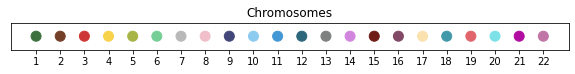

In [431]:
plt.figure(figsize = (10, 0.5))
plt.scatter(x =chr_palette['chr_number'], y =  [2] * chr_palette['chr_number'].shape[0], 
            c = chr_palette['color'], s = 100)
plt.yticks([])
plt.title('Chromosomes')
plt.savefig(fig_dir + 'chr_colors_horizontal.png', dpi = 500, bbox_inches="tight")
plt.show()

In [44]:
# Create network for old TFs
TF = 'KAT5'

# get diff map for old DE target genes and TF
TF_diff_map = diff.get_diff_map_TF_transition(diff_map, TF, "fc_61-85_86-96", data_dir, save_dir)

# transform to long format and filter for specific intermingling
diff_map_long = TF_diff_map.copy()
diff_map_long['target1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'target1', var_name = 'target2')
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])
#diff_map_long = diff_map_long[diff_map_long['value'] != 'shared']

# get genomic location of each gene
gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
gene_loci = gene_loci[gene_loci['gene'].isin(TF_diff_map.columns)]
gene_loci[['chr','chr_number', 'loc', 'loc_number']]=gene_loci.locus.str.split('_',expand=True)
gene_loci = gene_loci.merge(chr_palette, on = 'chr_number')

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'target1', 'target2', 'value')

# draw network
plt.figure(figsize = (15,15))
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)
pos['C1orf159'] = np.array([-3.8, -3.4])
pos['ATAD3B'] = np.array([-5.8,  0])
pos['CKAP2L'] = np.array([7, -3])
pos['PKMYT1'] = np.array([-3, 1.1])
pos['SLC9A3R2'] = np.array([-4.2,  0.8])
pos['RAC3'] = np.array([0.9, -0.8])
pos['SIVA1'] = np.array([-0.8, 3])

# Draw terminals 
gene_loci = gene_loci.set_index('gene')
gene_loci = gene_loci.reindex(network.nodes())
gene_loci['chr_number']=pd.Categorical(gene_loci['chr_number'], categories = [str(i) for i in range(1, 23)])  
gene_loci.loc['TK1, BIRC5', 'chr_number'] = '17'
gene_loci.loc['TK1, BIRC5', 'color'] = "#FAE1AE"


targets = [protein for protein in diff_map_long['target1'].unique() if protein != TF]
 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = targets,
                       node_color= gene_loci.loc[gene_loci.index != TF, 'color'],
                       node_size=400,
                       node_shape='o',
                       alpha=1)
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = [TF],
                       node_color = gene_loci.loc[gene_loci.index == TF, 'color'],
                       node_size=600,
                       node_shape='^',
                       alpha=1)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'shared'].index]
shared_edges = [(gene1, gene2) for (gene1, gene2) in shared_edges 
                if gene_loci.loc[gene1, 'chr_number'] != gene_loci.loc[gene2, 'chr_number']]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.8, 
                       alpha=0.3, 
                       edge_color='grey')

# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='magenta')

# Draw labels
labels = {protein: protein for protein in diff_map_long['target1'].unique() if protein != TF}
new_pos = {protein: np.array([x, y + 0.25]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = labels,
                        font_size=18)
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = {TF: TF},
                        font_color = gene_loci.loc[gene_loci.index == TF, 'color'].item(),
                        font_size=28)

plt.savefig(fig_dir + 'network_KAT5.png', dpi = 500, bbox_inches="tight")
plt.show()

(29, 2)


In [317]:
pos

{'C1orf159': array([-0.25108643,  1.3162739 ]),
 'ATAD3B': array([-1.26673289,  1.88121635]),
 'ENDOG': array([-2.28534774,  0.1910107 ]),
 'KAT5': array([-2.5404747 , -1.02294086]),
 'CCDC85C': array([2.2321898 , 2.22089338]),
 'SIVA1': array([-0.45002349,  2.95564026]),
 'CDCA4': array([0.70843904, 2.92763809]),
 'SLC9A3R2': array([-3.01016203,  1.36417481]),
 'PKMYT1': array([-3.24663902, -0.08839942]),
 'TK1, BIRC5': array([0.53386243, 0.05585069]),
 'SLC25A10': array([-0.27736648, -0.61942704]),
 'RAC3': array([ 0.36216703, -0.60037947]),
 'KIF2C': array([-2.18699387, -2.71010118]),
 'TNXB': array([-5.2828225 ,  0.96274434]),
 'CKAP2L': array([-2.93314978e+00, -1.08894197e-04]),
 'MXD3': array([1.94748736, 5.43951302]),
 'CDCA3': array([-2.5174944 ,  2.60563792]),
 'C7orf50': array([-6.01073193, -0.93203378]),
 'CHST12': array([-4.9530516 , -2.87311443]),
 'FAM83D': array([-1.88006014,  5.62439911]),
 'PRC1': array([-0.65253292, -2.85985276]),
 'SBNO2': array([ 0.0210158 , -3.8278

In [45]:
# Create network for old TFs
TF = 'RBBP5'

# get diff map for old DE target genes and TF
TF_diff_map = diff.get_diff_map_TF_transition(diff_map, TF, "fc_61-85_86-96", data_dir, save_dir)

# transform to long format and filter for specific intermingling
diff_map_long = TF_diff_map.copy()
diff_map_long['target1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'target1', var_name = 'target2')
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])
#diff_map_long = diff_map_long[diff_map_long['value'] != 'shared']

# get genomic location of each gene
gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
gene_loci = gene_loci[gene_loci['gene'].isin(TF_diff_map.columns)]
gene_loci[['chr','chr_number', 'loc', 'loc_number']]=gene_loci.locus.str.split('_',expand=True)
gene_loci = gene_loci.merge(chr_palette, on = 'chr_number')

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'target1', 'target2', 'value')

# draw network
plt.figure(figsize = (15.5,11.5))
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)

# Draw terminals 
gene_loci = gene_loci.set_index('gene')
gene_loci = gene_loci.reindex(network.nodes())
gene_loci['chr_number']=pd.Categorical(gene_loci['chr_number'], categories = [str(i) for i in range(1, 23)])  
gene_loci.loc['TK1, BIRC5', 'chr_number'] = '17'
gene_loci.loc['TK1, BIRC5', 'color'] = "#FAE1AE"
gene_loci.loc['CDCA5, SAC3D1', 'chr_number'] = '11'
gene_loci.loc['CDCA5, SAC3D1', 'color'] = "#C4451C"
gene_loci.loc['DVL1, ATAD3B', 'chr_number'] = '1'
gene_loci.loc['DVL1, ATAD3B', 'color'] = "#3C723E"


targets = [protein for protein in diff_map_long['target1'].unique() if protein != TF]
 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = targets,
                       node_color= gene_loci.loc[gene_loci.index != TF, 'color'],
                       node_size=400,
                       node_shape='o',
                       alpha=1)
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = [TF],
                       node_color = gene_loci.loc[gene_loci.index == TF, 'color'],
                       node_size=600,
                       node_shape='^',
                       alpha=1)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'shared'].index]
shared_edges = [(gene1, gene2) for (gene1, gene2) in shared_edges 
                if gene_loci.loc[gene1, 'chr_number'] != gene_loci.loc[gene2, 'chr_number']]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.8, 
                       alpha=0.3, 
                       edge_color='grey')

# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='magenta')

# Draw labels
labels = {protein: protein for protein in diff_map_long['target1'].unique() if protein != TF}
new_pos = {protein: np.array([x, y + 0.5]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = labels,
                        font_size=18)
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = {TF: TF},
                        font_color = gene_loci.loc[gene_loci.index == TF, 'color'].item(),
                        font_size=28)

plt.savefig(fig_dir + 'network_RBBP5.png', dpi = 500, bbox_inches="tight")
plt.show()

(62, 2)


In [39]:
# Create network for old TFs
TF = 'CEBPB'

# get diff map for old DE target genes and TF
TF_diff_map = diff.get_diff_map_TF_transition(diff_map, TF, "fc_16-26_27-60", data_dir, save_dir)

# transform to long format and filter for specific intermingling
diff_map_long = TF_diff_map.copy()
diff_map_long['target1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'target1', var_name = 'target2')
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])
#diff_map_long = diff_map_long[diff_map_long['value'] != 'shared']

# get genomic location of each gene
gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
gene_loci = gene_loci[gene_loci['gene'].isin(TF_diff_map.columns)]
gene_loci[['chr','chr_number', 'loc', 'loc_number']]=gene_loci.locus.str.split('_',expand=True)
gene_loci = gene_loci.merge(chr_palette, on = 'chr_number')

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'target1', 'target2', 'value')

# draw network
plt.figure(figsize = (15.5,11.5))
pos = nx.spring_layout(network,
                                    weight=None,
                                    scale=10)

# Draw terminals 
gene_loci = gene_loci.set_index('gene')
gene_loci = gene_loci.reindex(network.nodes())
gene_loci['chr_number']=pd.Categorical(gene_loci['chr_number'], categories = [str(i) for i in range(1, 23)])  
gene_loci.loc['ABCA5, ABCA6', 'chr_number'] = '17'
gene_loci.loc['ABCA5, ABCA6', 'color'] = "#FAE1AE"
gene_loci.loc['PRCD, CYGB', 'chr_number'] = '17'
gene_loci.loc['PRCD, CYGB', 'color'] = "#FAE1AE"
gene_loci.loc['FBLN5, TC2N', 'chr_number'] = '14'
gene_loci.loc['FBLN5, TC2N', 'color'] = "#D285DE"
gene_loci.loc['C1R, C1RL', 'chr_number'] = '12'
gene_loci.loc['C1R, C1RL', 'color'] = "#2C677C"

targets = [protein for protein in diff_map_long['target1'].unique() if protein != TF]
 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = targets,
                       node_color= gene_loci.loc[gene_loci.index != TF, 'color'],
                       node_size=400,
                       node_shape='o',
                       alpha=1)
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = [TF],
                       node_color = gene_loci.loc[gene_loci.index == TF, 'color'],
                       node_size=600,
                       node_shape='^',
                       alpha=1)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'shared'].index]
shared_edges = [(gene1, gene2) for (gene1, gene2) in shared_edges 
                if gene_loci.loc[gene1, 'chr_number'] != gene_loci.loc[gene2, 'chr_number']]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.8, 
                       alpha=0.3, 
                       edge_color='grey')

# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='magenta')

# Draw labels
labels = {protein: protein for protein in diff_map_long['target1'].unique() if protein != TF}
new_pos = {protein: np.array([x, y + 0.5]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = labels,
                        font_size=18)
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = {TF: TF},
                        font_color = gene_loci.loc[gene_loci.index == TF, 'color'].item(),
                        font_size=28)

plt.savefig(fig_dir + 'network_CEBPB.png', dpi = 500, bbox_inches="tight")
plt.show()

(66, 2)


KeyError: 'chr_number'

In [59]:
# Create network for young TFs
TF = 'SUMO2'

# get diff map for old DE target genes and TF
TF_diff_map = diff.get_diff_map_TF_transition(diff_map, TF, "fc_16-26_27-60", data_dir, save_dir)

# transform to long format and filter for specific intermingling
diff_map_long = TF_diff_map.copy()
diff_map_long['target1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'target1', var_name = 'target2')
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])
#diff_map_long = diff_map_long[diff_map_long['value'] != 'shared']

# get genomic location of each gene
gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
gene_loci = gene_loci[gene_loci['gene'].isin(TF_diff_map.columns)]
gene_loci[['chr','chr_number', 'loc', 'loc_number']]=gene_loci.locus.str.split('_',expand=True)
gene_loci = gene_loci.merge(chr_palette, on = 'chr_number')

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'target1', 'target2', 'value')

# draw network
plt.figure(figsize = (15.5,11.5))
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)

# Draw terminals 
gene_loci = gene_loci.set_index('gene')
gene_loci = gene_loci.reindex(network.nodes())
gene_loci['chr_number']=pd.Categorical(gene_loci['chr_number'], categories = [str(i) for i in range(1, 23)])  
gene_loci.loc['PRCD, CYGB', 'chr_number'] = '17'
gene_loci.loc['PRCD, CYGB', 'color'] = "#FAE1AE"
gene_loci.loc['TC2N, FBLN5', 'chr_number'] = '14'
gene_loci.loc['TC2N, FBLN5', 'color'] = "#D285DE"

targets = [protein for protein in diff_map_long['target1'].unique() if protein != TF]
 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = targets,
                       node_color= gene_loci.loc[gene_loci.index != TF, 'color'],
                       node_size=400,
                       node_shape='o',
                       alpha=1)
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = [TF],
                       node_color = gene_loci.loc[gene_loci.index == TF, 'color'],
                       node_size=600,
                       node_shape='^',
                       alpha=1)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'shared'].index]
shared_edges = [(gene1, gene2) for (gene1, gene2) in shared_edges 
                if gene_loci.loc[gene1, 'chr_number'] != gene_loci.loc[gene2, 'chr_number']]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.8, 
                       alpha=0.3, 
                       edge_color='grey')

# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='magenta')

# Draw labels
labels = {protein: protein for protein in diff_map_long['target1'].unique() if protein != TF}
new_pos = {protein: np.array([x, y + 0.5]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = labels,
                        font_size=18)
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = {TF: TF},
                        font_color = gene_loci.loc[gene_loci.index == TF, 'color'].item(),
                        font_size=28)

plt.savefig(fig_dir + 'network_SUMO2.png', dpi = 500, bbox_inches="tight")
plt.show()

(22, 2)


KeyError: 'chr_number'

In [476]:
gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
gene_loci[gene_loci['gene'] == 'TC2N']

,gene,locus
9534,TC2N,chr_14_loc_91750000


In [471]:
gene_loci.tail(n = 30)

,locus,chr,chr_number,loc,loc_number,color
gene,,,,,,
ZNF608,chr_5_loc_124500000,chr,5,loc,124500000,#A7B547
CD74,chr_5_loc_150250000,chr,5,loc,150250000,#A7B547
"FBLN5, TC2N",NaN,NaN,NaN,NaN,NaN,NaN
MOAP1,chr_14_loc_93000000,chr,14,loc,93000000,#D285DE
DNASE1L3,chr_3_loc_58000000,chr,3,loc,58000000,#CD3836
ACKR4,chr_3_loc_132500000,chr,3,loc,132500000,#CD3836
IGSF10,chr_3_loc_151250000,chr,3,loc,151250000,#CD3836
PPARGC1A,chr_4_loc_23750000,chr,4,loc,23750000,#F7D24A
PDGFRA,chr_4_loc_54000000,chr,4,loc,54000000,#F7D24A


In [65]:
# Intermingling network for all upregulated young and downregulated old DE targets plus bridge TFs

# load up/downregulated DE genes
DE_genes = pd.read_csv(save_dir+'DE_genes/DE_updown.csv')
DE_genes = DE_genes[((DE_genes['transition'] == 'fc_16-26_27-60') & (DE_genes['updown'] == 'up')) | 
                        ((DE_genes['transition'] == 'fc_61-85_86-96') & (DE_genes['updown'] == 'down'))]
    
# load loci of all DE targets
all_gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
DE_genes = DE_genes.merge(all_gene_loci, on = "gene")
DE_genes = DE_genes[['gene', 'locus', 'updown']]

# merge genes from the same locus
DE_genes['gene'] = DE_genes.groupby(['locus'])['gene'].transform(lambda x: ', '.join(x))
DE_genes = DE_genes.drop_duplicates()

# add loci of the bridge TFs
TF_groups = pd.read_csv(save_dir+'pcst/incl_TFs_design2.csv')
bridge_TFs = pd.DataFrame({'gene': TF_groups.loc[TF_groups['net'].isin(['young_net', 'old_net']), 'TF'].unique()})
bridge_TFs = bridge_TFs.merge(all_gene_loci, on = "gene")
bridge_TFs['updown'] = 'Bridge TF'

# combine DE genes and bridge TFs
all_nodes = pd.concat([bridge_TFs, DE_genes])
all_nodes['chromosome'] = [locus.split("_")[1] for locus in all_nodes['locus']]
all_nodes = all_nodes.groupby(['gene'], as_index = False).aggregate('first')

# create diff_map 
diff_map_long = diff_map.copy()
diff_map_long['loc1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
diff_map_long = diff_map_long[diff_map_long['loc1'].isin(all_nodes['locus']) & diff_map_long['loc2'].isin(all_nodes['locus'])]
diff_map_long = all_nodes.rename(columns={"gene": "gene1", "locus": "loc1", "updown": "group1"}).merge(diff_map_long, on = 'loc1')
diff_map_long = all_nodes.rename(columns={"gene": "gene2", "locus": "loc2","updown": "group2"}).merge(diff_map_long, on = 'loc2')
# remove intrachromosomal edges
diff_map_long['chr1'] = [locus.split("_")[1] for locus in diff_map_long['loc1']]
diff_map_long['chr2'] = [locus.split("_")[1] for locus in diff_map_long['loc2']]
diff_map_long = diff_map_long[diff_map_long['chr1'] != diff_map_long['chr2']]
diff_map_long = diff_map_long[['gene1', 'gene2', 'value']]
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long_wo_shared = diff_map_long[diff_map_long['value'] != 3]
# add self-edges to not loose any nodes
diff_map_long_wo_shared = pd.concat([diff_map_long_wo_shared, 
                                    pd.DataFrame({'gene1': all_nodes['gene'], 
                                                 'gene2': all_nodes['gene'], 
                                                  'value': 0})])

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'gene1', 'gene2', 'value')
network_wo_shared = nx.from_pandas_edgelist(diff_map_long_wo_shared, 'gene1', 'gene2', 'value')
# add all nodes from network to network_wo_shared
all_nodes = all_nodes.set_index('gene')
all_nodes = all_nodes.reindex(network.nodes())
all_nodes['chromosome']=pd.Categorical(all_nodes['chromosome'], categories = [str(i) for i in range(1, 23)]) 

In [98]:
# Intermingling network for all DE targets of a bridge TF in a given network
TF = 'RBBP5'
network = 'S3' #save_dir, diff_map

if network == 'S1':
    transition = 'fc_16-26_27-60'
elif network == 'S3':
    transition = 'fc_61-85_86-96'
else:
    print('Error: please input S1 or S3 as network')

# load DE genes
DE_genes = pd.read_csv(save_dir+'DE_genes/DE_updown.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]
DE_genes = DE_genes[((DE_genes['transition'] == 'fc_16-26_27-60') & (DE_genes['updown'] == 'up')) | 
                        ((DE_genes['transition'] == 'fc_61-85_86-96') & (DE_genes['updown'] == 'down'))]

# filter to the targets of the TF of interest
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]
DE_genes = DE_genes[DE_genes['gene'].isin(TF_targets['target'])]

# load loci of all DE targets
all_gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
DE_genes = DE_genes.merge(all_gene_loci, on = "gene")
DE_genes = DE_genes[['gene', 'locus', 'updown']]

# merge genes from the same locus
DE_genes['gene'] = DE_genes.groupby(['locus'])['gene'].transform(lambda x: ', '.join(x))
DE_genes = DE_genes.drop_duplicates()

# add locus of the bridge TFs
bridge_TF = pd.DataFrame({'gene': [TF]})
bridge_TF = bridge_TF.merge(all_gene_loci, on = "gene")
bridge_TF['updown'] = 'Bridge TF'

# combine DE genes and bridge TFs
all_nodes = pd.concat([bridge_TF, DE_genes])
all_nodes['chromosome'] = [locus.split("_")[1] for locus in all_nodes['locus']]
all_nodes = all_nodes.groupby(['gene'], as_index = False).aggregate('first')

# define colors based on the chromosome
chr_palette = pd.DataFrame({'chromosome': [str(i) for i in range(1, 23)],
                           'color': ["#4397D4", "#743F27", "#CD3836", "#F7D24A", "#A7B547", "#76CE97", 
                                     "#B9B9B9", "#F0BFC9", "#434679", "#8CCBEF", "#3C723E", 
                                     "#2C677C", "#7E8180", "#D285DE", "#6F1C16", "#814965", "#FAE1AE", 
                                     "#4299A9", "#E1646B", "#B10DA1", "#7DE2E7", "#C075A6"] })
all_nodes = all_nodes.merge(chr_palette, on = 'chromosome')

# create diff_map 
diff_map_long = diff_map.copy()
diff_map_long['loc1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
diff_map_long = diff_map_long[diff_map_long['loc1'].isin(all_nodes['locus']) & diff_map_long['loc2'].isin(all_nodes['locus'])]
diff_map_long = all_nodes.rename(columns={"gene": "gene1", "locus": "loc1", 
                                          "updown": "group1", "chromosome": "chr1"}).merge(diff_map_long, on = 'loc1')
diff_map_long = all_nodes.rename(columns={"gene": "gene2", "locus": "loc2",
                                          "updown": "group2", "chromosome": "chr2"}).merge(diff_map_long, on = 'loc2')
# remove intrachromosomal edges
diff_map_long = diff_map_long[diff_map_long['chr1'] != diff_map_long['chr2']]
diff_map_long = diff_map_long[['gene1', 'gene2', 'value']]
diff_map_long = diff_map_long[diff_map_long['value'] != 0]

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'gene1', 'gene2', 'value')
network.add_nodes_from(all_nodes['gene'])
all_nodes = all_nodes.set_index('gene')
all_nodes = all_nodes.reindex(network.nodes())
all_nodes['chromosome']=pd.Categorical(all_nodes['chromosome'], categories = [str(i) for i in range(1, 23)]) 

chromosome_dict = {node: all_nodes.loc[node, 'chromosome'] for node in all_nodes.index}
nx.set_node_attributes(network, chromosome_dict, name='chromosome')
color_dict = {node: all_nodes.loc[node, 'color'] for node in all_nodes.index}
nx.set_node_attributes(network, color_dict, name='color')
node_type_dict = {node: all_nodes.loc[node, 'updown'] for node in all_nodes.index}
nx.set_node_attributes(network, node_type_dict, name='node_type')

In [103]:
diff_map_long[diff_map_long['value'] == 2].shape

(62, 4)

In [97]:
# export to cytoscape
cy = nx.readwrite.json_graph.cytoscape_data(network)

# add positions of nodes
pos = nx.layout.kamada_kawai_layout(network, 
                                    weight=None,
                                    scale=10)
for node_id in range(len(cy['elements']['nodes'])): 
    mydict = cy['elements']['nodes'][node_id]
    node_name = mydict['data']['name']
    mydict['data']['label'] = node_name
    mydict['position'] = {'x':  40 * pos[node_name][0], 'y':  40 * pos[node_name][1]}
    
for edge_id in range(len(cy['elements']['edges'])):
    edge_dict = cy['elements']['edges'][edge_id]
    intermingling = edge_dict['data']['value']
    if intermingling == 1: 
        im = 'young'
    elif intermingling == 2:
        im = 'old'
    else:
        im = 'shared'
    edge_dict['classes'] = im

with open(save_dir+"cytoscape/cytoscape_"+TF+".json", "w") as outfile:
    json.dump(cy, outfile)

In [24]:
cy

{'data': [],
 'directed': False,
 'multigraph': False,
 'elements': {'nodes': [{'data': {'chromosome': '1',
     'color': '#3C723E',
     'node_type': 'Bridge TF',
     'id': 'RBBP5',
     'value': 'RBBP5',
     'name': 'RBBP5',
     'label': 'RBBP5'},
    'position': {'x': 344.35513890110474, 'y': -354.86147626222714}},
   {'data': {'chromosome': '19',
     'color': '#E1646B',
     'node_type': 'down',
     'id': 'ALDH16A1',
     'value': 'ALDH16A1',
     'name': 'ALDH16A1',
     'label': 'ALDH16A1'},
    'position': {'x': 512.5918777591461, 'y': 381.26017760032965}},
   {'data': {'chromosome': '20',
     'color': '#7DE2E7',
     'node_type': 'down',
     'id': 'E2F1',
     'value': 'E2F1',
     'name': 'E2F1',
     'label': 'E2F1'},
    'position': {'x': 186.56764397197304, 'y': 160.11530293400457}},
   {'data': {'chromosome': '20',
     'color': '#7DE2E7',
     'node_type': 'down',
     'id': 'RTEL1-TNFRSF6B',
     'value': 'RTEL1-TNFRSF6B',
     'name': 'RTEL1-TNFRSF6B',
     'labe

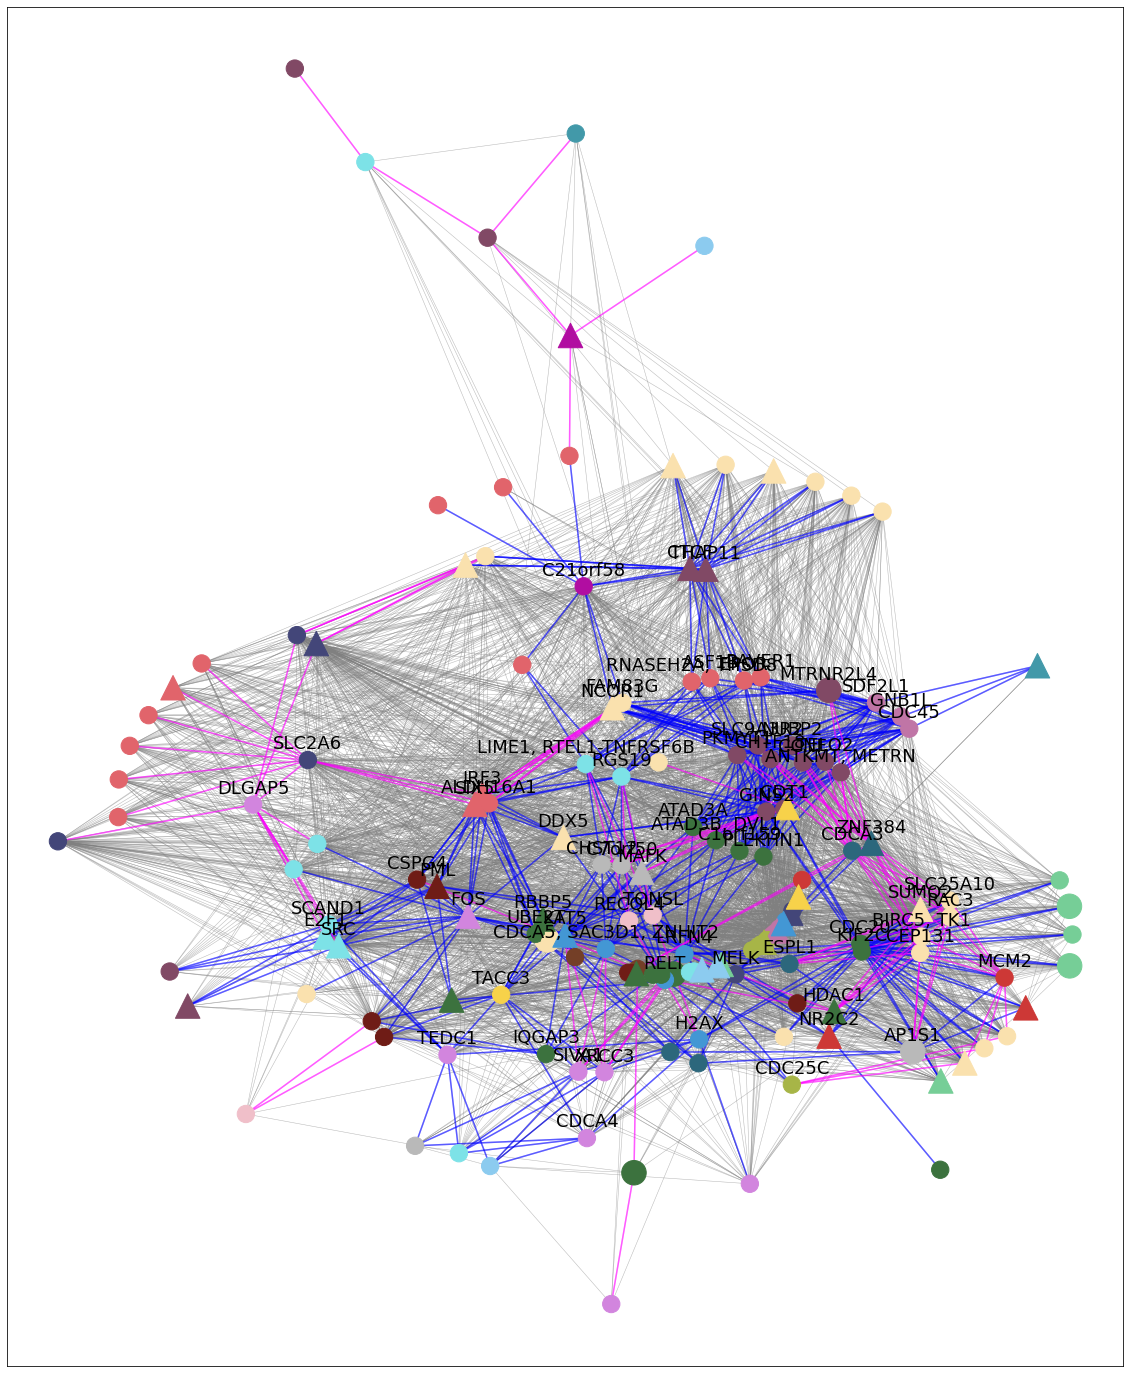

In [438]:
# draw network
plt.figure(figsize = (20,25))
pos = nx.layout.kamada_kawai_layout(network_wo_shared,
                                    weight=None,
                                    scale=10)

# Draw terminals 
DE_up_nodes = all_nodes[all_nodes['updown'] == 'up'].index.tolist()
DE_down_nodes = all_nodes[all_nodes['updown'] == 'down'].index.tolist()
TF_nodes = all_nodes[all_nodes['updown'] == 'Bridge TF'].index.tolist()
# Upregulated DE genes 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = DE_up_nodes,
                       node_color= all_nodes.loc[DE_up_nodes, 'color'],
                       node_size=600,
                       node_shape='o',
                       alpha=1)
# Downregulated DE genes 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = DE_down_nodes,
                       node_color= all_nodes.loc[DE_down_nodes, 'color'],
                       node_size=300,
                       node_shape='o',
                       alpha=1)
# Bridge TFs
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = TF_nodes,
                       node_color = all_nodes.loc[TF_nodes, 'color'],
                       node_size=600,
                       node_shape='^',
                       alpha=1)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 3].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.5, 
                       alpha=0.3, 
                       edge_color='grey')
# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 1].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=1.5, 
                       alpha=0.4, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 2].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=1.5, 
                       alpha=0.4, 
                       edge_color='magenta')

# Draw labels
labels = {}
for node in all_nodes.index:
    degree = diff_map_long_wo_shared[(diff_map_long_wo_shared['gene1'] == node)].shape[0]
    if degree > 5: 
        labels[node] = node

new_pos = {protein: np.array([x, y + 0.2]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        pos = new_pos,
                        labels = labels,
                        font_size=18)


plt.savefig(fig_dir + 'network_all_S3_TFs_with_shared.png', dpi = 500, bbox_inches="tight")
plt.show()

## d) DE genes vs. non-DE genes

<Figure size 432x288 with 0 Axes>

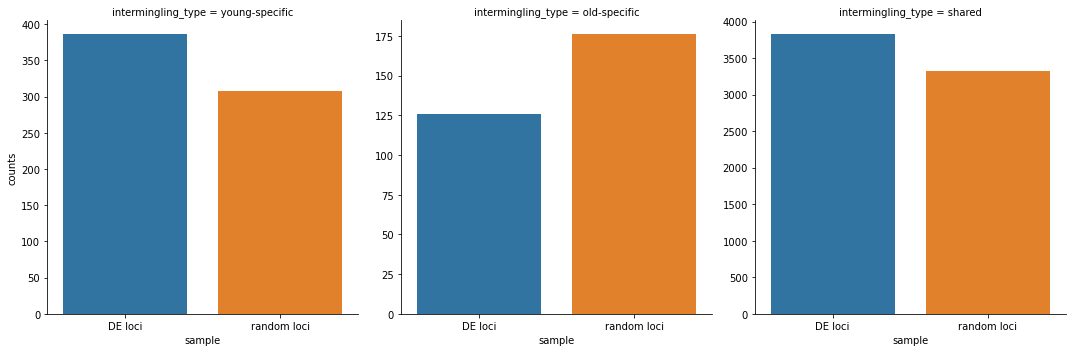

In [191]:
# load DE genes and their loci
transition = 'fc_61-85_86-96'

DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
DE_loci = TF_targets.loc[TF_targets['target'].isin(DE_genes['gene']), 'locus'].unique()
DE_loci = [loc for loc in DE_loci if loc in diff_map.columns]
DE_loci = pd.DataFrame({'loc': DE_loci, 'chrom': [loc.split('_')[1] for loc in DE_loci]})

# sample same number of active random loci per chromosome
all_non_DE_loci = TF_targets[TF_targets['expressed'] == True]
all_non_DE_loci = all_non_DE_loci.loc[~all_non_DE_loci['locus'].isin(DE_loci['loc']), 'locus']
all_non_DE_loci = [loc for loc in all_non_DE_loci if loc in diff_map.columns]
all_non_DE_loci = pd.DataFrame({'loc': all_non_DE_loci, 'chrom': [loc.split('_')[1] for loc in all_non_DE_loci]})
random_non_DE_loci = []
for chrom in range(1, 23):
    n_DE_genes = DE_loci[DE_loci['chrom'] == str(chrom)].shape[0]
    sample = all_non_DE_loci.loc[all_non_DE_loci['chrom'] == str(chrom), 'loc'].sample(n_DE_genes, random_state=20221215)
    random_non_DE_loci.append(sample)
# flatten list 
random_non_DE_loci = list(itertools.chain(*random_non_DE_loci))

# create diff map subset for DE and random non_DE loci
diff_map_DE = diff_map.loc[DE_loci['loc'], DE_loci['loc']]
diff_map_random = diff_map.loc[random_non_DE_loci, random_non_DE_loci]

# count intermingling types in the diff_maps
intermingling = pd.DataFrame({'sample': ['DE loci', 'DE loci', 'DE loci', 'random loci', 
                                         'random loci', 'random loci'],
                             'intermingling_type': ['young-specific', 'old-specific', 'shared', 
                                                    'young-specific', 'old-specific', 'shared'],
                             'counts': [(diff_map_DE == 1).sum().sum(), (diff_map_DE == 2).sum().sum(), (diff_map_DE == 3).sum().sum(),
                                       (diff_map_random == 1).sum().sum(), (diff_map_random == 2).sum().sum(), (diff_map_random == 3).sum().sum()]})

# plot the results
plt.figure()
sns.catplot(
    data=intermingling, x='sample', y='counts',
    col='intermingling_type', kind='bar', col_wrap=3, sharey= False
) 
plt.show()

## e) Quantification of young/old-specific intermingling for TF groups

In [216]:
# helper function that returns the percentage of young-specific and old-specific intermingling out of all intermingling
def get_intermingling_percentages(DE_diff_map, TF_targets): 
    TF_diff_long = DE_diff_map.loc[TF_targets['target'], TF_targets['target']]
    TF_diff_long['loc1'] = TF_diff_long.index
    TF_diff_long = TF_diff_long.melt(id_vars = 'loc1', var_name = 'loc2')
    young_percent = TF_diff_long['value'].isin([1]).sum() / TF_diff_long['value'].isin([1, 2, 3]).sum()
    old_percent = TF_diff_long['value'].isin([2]).sum() / TF_diff_long['value'].isin([1, 2, 3]).sum()
    return young_percent, old_percent

In [261]:
# Select TFs identified in the network of interest
TF_list = pd.concat([pd.DataFrame({'TF': list(young_TFs.intersection(middle_TFs.intersection(old_TFs))),
                                   'net': 'shared'}),
                     pd.DataFrame({'TF': list(young_TFs.difference(middle_TFs.union(old_TFs))),
                                   'net': 'young'}),
                     pd.DataFrame({'TF': list(old_TFs.difference(middle_TFs.union(young_TFs))),
                                   'net': 'old'})])

# alternative: only take TFs that target significantly more DE genes
#TF_list = pd.concat([pd.DataFrame({'TF': ['MAZ', 'CEBPB', 'FLI1', 'SUMO2', 'AHR'],
#                                   'net': 'young'}),
#                     pd.DataFrame({'TF': ['E2F1', 'KDM4C', 'POLR2A', 'HOXA6', 'HDAC1',
#                                         'TAF3', 'GTF2B', 'RBBP5', 'NOTCH1', 'GABPA', 'MNT', 
#                                         'KAT5', 'BMI1', 'BRD2'],
#                                   'net': 'old'})])

# Load young and old DE genes 
DE_diff_map_young = diff.get_diff_map_DE(diff_map, "fc_16-26_27-60", data_dir, save_dir)
DE_diff_map_old = diff.get_diff_map_DE(diff_map, "fc_61-85_86-96", data_dir, save_dir)

spec_intermingling = pd.DataFrame({'TF': [], 'net': [], 'DE': [], 'young_percent': [], 'old_percent': []})
for ix in tqdm(range(TF_list.shape[0])):
    time.sleep(0.01)
    TF = TF_list.iloc[ix, 0]
    net = TF_list.iloc[ix, 1]
    
    # load DE targets of selected TF
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    TF_targets_young = TF_targets[TF_targets['target'].isin(DE_diff_map_young.columns)]
    TF_targets_old = TF_targets[TF_targets['target'].isin(DE_diff_map_old.columns)]
    
    # calculate percentages of cell-state specific intermingling
    young_im_young_DE, old_im_young_DE = get_intermingling_percentages(DE_diff_map_young, TF_targets_young)
    young_im_old_DE, old_im_old_DE = get_intermingling_percentages(DE_diff_map_old, TF_targets_old)
    
    spec_intermingling = pd.concat([spec_intermingling, 
                                   pd.DataFrame({'TF': [TF, TF], 'net': [net, net],
                                                 'DE': ['young', 'old'],
                                                 'young_percent': [young_im_young_DE, young_im_old_DE],
                                                 'old_percent': [old_im_young_DE, old_im_old_DE]})], 
                                   ignore_index = True)
     
spec_intermingling.to_csv(hic_dir + 'spec_intermingling_allTFs.csv', index = False)    
print(spec_intermingling.head())

(117, 2)
(150, 2)


 20%|████████████████████████▏                                                                                                | 12/60 [00:08<00:33,  1.43it/s]/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:41<00:00,  1.43it/s]

       TF     net     DE  young_percent  old_percent
0  NOTCH1  shared  young       0.009346     0.056075
1  NOTCH1  shared    old       0.094874     0.026014
2   GATA2  shared  young       0.000000     0.000000
3   GATA2  shared    old       0.142857     0.000000
4     AHR  shared  young       0.000000     0.000000


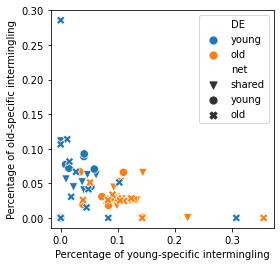

In [262]:
plt.figure(figsize = (4,4))
sns.scatterplot(data = spec_intermingling, x = 'young_percent', y = 'old_percent', hue = "DE", 
                style = "net", markers = {"young": 'o', "old": 'X', "shared": "v"}, s = 70)
plt.legend(markerscale=1.2)
plt.xlabel("Percentage of young-specific intermingling")
plt.ylabel("Percentage of old-specific intermingling")
plt.show()

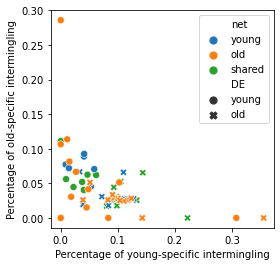

In [263]:
plt.figure(figsize = (4,4))
sns.scatterplot(data = spec_intermingling, x = 'young_percent', y = 'old_percent', style = "DE", 
                hue = "net", markers = {"young": 'o', "old": 'X'}, s = 50, hue_order = ['young', 'old', 'shared'])
plt.legend(markerscale=1.2)
plt.xlabel("Percentage of young-specific intermingling")
plt.ylabel("Percentage of old-specific intermingling")
plt.show()

<Figure size 432x288 with 0 Axes>

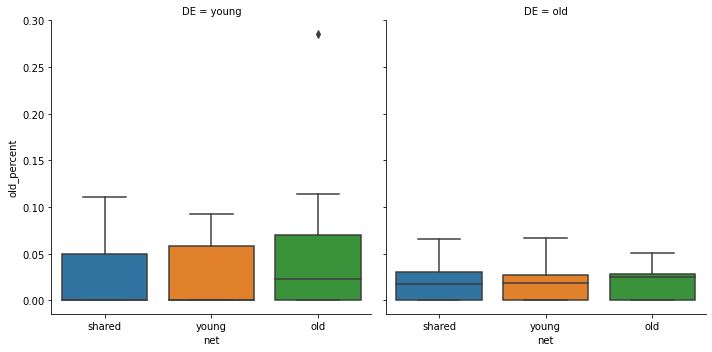

In [254]:
plt.figure()
sns.catplot(data = spec_intermingling, x = 'net', y = 'old_percent', kind = 'box', col = 'DE')
plt.show()

## Diff map for non DE targets

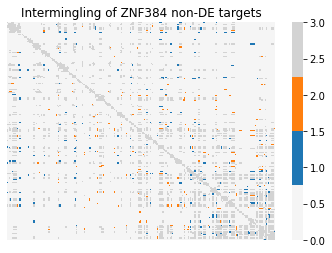

In [571]:
TF = "ZNF384"
# load loci of non-DE TF targets
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]
DE_genes = pd.read_csv(save_dir+'DE_genes/DE_updown.csv')
TF_targets = TF_targets[~TF_targets['target'].isin(DE_genes['gene'])]

# get all loci including TF targets
locus_order = [loc for loc in diff_map.columns if loc in TF_targets['locus'].unique()]

# diff map for selected loci
TF_diff_map = diff_map.loc[locus_order, locus_order]

# plot the results
palette = sns.color_palette("tab10")
colors = ['whitesmoke', palette[0], palette[1], 'lightgrey']
cmap = ListedColormap(colors)

g = sns.heatmap(TF_diff_map, cmap = cmap, xticklabels=False, yticklabels=False)
plt.ylabel('') 
plt.xlabel('')
plt.title('Intermingling of ' + TF + ' non-DE targets')
plt.savefig(fig_dir + 'diff_map_non_DE_targets_'+ TF + '.png', dpi = 500, bbox_inches="tight")
plt.show()

In [498]:
young_specific = np.count_nonzero(TF_diff_map.to_numpy() == 1) / (TF_diff_map.shape[0] * TF_diff_map.shape[0]) *100
old_specific = np.count_nonzero(TF_diff_map.to_numpy() == 2) / (TF_diff_map.shape[0] * TF_diff_map.shape[0]) *100
print('Percent of young-specific intermingling: ', young_specific)
print('Percent of old-specific intermingling: ', old_specific)

Percent of young-specific intermingling:  0.4304101332982961
Percent of old-specific intermingling:  0.4144418776612805


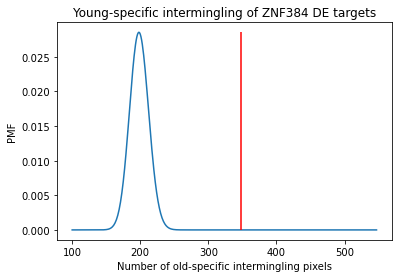

p-value for Young-specific intermingling of DE targets of ZNF384: 1.3593138903394613e-22


In [591]:
# Hypergeometric test for selected TF and intermingling type
TF = "ZNF384"
intermingling = "Young"

if intermingling == "Young":
    im_type = 1
else:
    im_type = 2

# create diff map for all loci of TF's targets
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]
locus_order = [loc for loc in diff_map.columns if loc in TF_targets['locus'].unique()]
TF_diff_map = diff_map.loc[locus_order, locus_order]

# create diff map for DE targets of the TF
DE_genes = pd.read_csv(save_dir+'DE_genes/DE_updown.csv')
DE_genes[((DE_genes['transition'] == 'fc_16-26_27-60') & (DE_genes['updown'] == 'up')) | 
                        ((DE_genes['transition'] == 'fc_61-85_86-96') & (DE_genes['updown'] == 'down'))] # filter for young DE and old DE genes
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
locus_order = [loc for loc in diff_map.columns if loc in TF_targets['locus'].unique()]
TF_DE_diff_map = diff_map.loc[locus_order, locus_order]

# Hypergeometric parameters 
N = TF_diff_map.shape[0] * TF_diff_map.shape[0] # total number of pixels in diff map of all targets
K = np.count_nonzero(TF_diff_map.to_numpy() == im_type) # number of pixels with young/old specific intermingling in diff map of all targets
n = TF_DE_diff_map.shape[0] * TF_DE_diff_map.shape[0] # total number of pixels in diff map of DE targets
k = np.count_nonzero(TF_DE_diff_map.to_numpy() == im_type) # number of pixels with young/old specific intermingling in diff map of DE targets

# calculate density 
k_list = np.arange(100, k + 200, 1)
rv = stats.hypergeom(N, K, n)
pmf = rv.pmf(k_list)

plt.figure()
plt.plot(k_list, pmf)
plt.vlines(k, 0, max(pmf), colors = 'red')
plt.title(intermingling +'-specific intermingling of '+ TF + ' DE targets') 
plt.xlabel('Number of old-specific intermingling pixels')
plt.ylabel('PMF')
plt.savefig(fig_dir + intermingling +'-specific_intermingling_of_'+ TF + '_DE_targets.png', dpi = 500, bbox_inches="tight")
plt.show()

# Compute p-value
pval = stats.hypergeom.sf(k, N, K, n)
print('p-value for ' + intermingling+ '-specific intermingling of DE targets of ' + TF + ': '+ str(pval))

## Networks on locus level

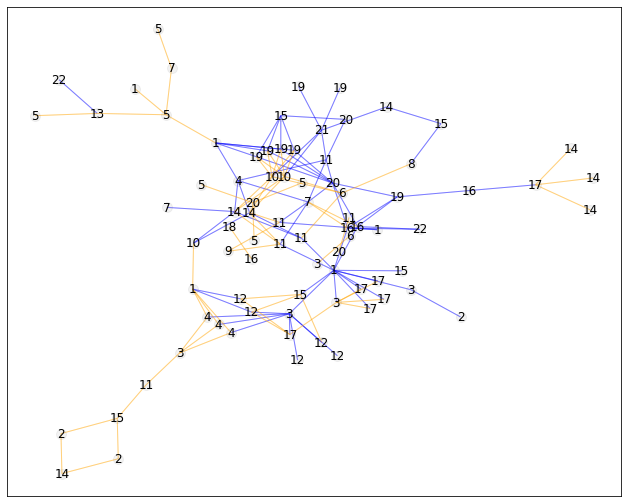

In [529]:
# Network on loci level (for one TF or random loci)
TF = 'random' # TF name or random

if TF == "random": 
    # select random loci
    random.seed(a=202302)
    random_loci = random.sample(list(diff_map.columns), 200)
    diff_map_long = diff_map.loc[random_loci, random_loci]
else:
    # load DE genes
    DE_genes = pd.read_csv(save_dir+'DE_genes/DE_updown.csv')
    DE_genes = DE_genes[DE_genes['transition'].isin(['fc_16-26_27-60','fc_61-85_86-96'])]
    DE_genes = DE_genes[((DE_genes['transition'] == 'fc_16-26_27-60') & (DE_genes['updown'] == 'up')) | 
                        ((DE_genes['transition'] == 'fc_61-85_86-96') & (DE_genes['updown'] == 'down'))]
    
    # load loci of all DE targets
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    selected_loci = [loc for loc in list(TF_targets['locus'].unique()) if loc in diff_map.columns]
    diff_map_long = diff_map.loc[selected_loci, selected_loci]

diff_map_long['target1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'target1', var_name = 'target2')
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])
diff_map_long = diff_map_long[diff_map_long['value'] != 'shared']
diff_map_long.to_csv(hic_dir+'difference_maps/diff_map_' + TF + '.csv', index = False)

network = nx.from_pandas_edgelist(diff_map_long, 'target1', 'target2', 'value')

plt.figure(figsize = (11,9))
# Draw
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)
# Draw terminals 
nx.draw_networkx_nodes(network, 
                       pos,
                       node_color= 'grey', 
                       node_size=100,
                       node_shape='o',
                       alpha=0.1)
# Draw edges
# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=1.0, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'target1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'target2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=1.0, 
                       alpha=0.3, 
                       edge_color='orange')

# Draw labels
labels = dict([(name, name.split("_")[1]) for name in network.nodes])          
nx.draw_networkx_labels(network,
                        pos,
                        labels,
                        font_size=12)
ax.axis('off')
plt.show()

## Circular plot of amount of shared targets

In [276]:
def filter_DE_genes(DE_genes, net_TF1, net_TF2):
    transitions = []
    if net_TF1 == 'young_net' or net_TF2 == 'young_net':
        transitions.append('fc_16-26_27-60')
    if net_TF1 == 'middle_net' or net_TF2 == 'middle_net':
        transitions.append('fc_27-60_61-85')
    if net_TF1 == 'old_net' or net_TF2 == 'old_net':
        transitions.append('fc_61-85_86-96')
    if net_TF1 == 'shared' and net_TF2 == 'shared':
        transitions = ['fc_16-26_27-60', 'fc_27-60_61-85', 'fc_61-85_86-96']    
    DE_genes = DE_genes[DE_genes['transition'].isin(transitions)]

    return DE_genes

In [277]:
# Use a hypergeometric distribution to get p-values for number of shared targets between TF pairs
# load DE genes and TF groups with their targets
DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')
transitions = ['fc_16-26_27-60', 'fc_27-60_61-85', 'fc_61-85_86-96']    
DE_genes = DE_genes[DE_genes['transition'].isin(transitions)]
TF_groups = pd.read_csv(save_dir+'pcst/specific_TFs_targets.csv')
TF_groups = TF_groups[TF_groups['target'].isin(DE_genes['gene'])]
n_DE_genes =  len(TF_groups['target'].unique()) # M = total number of objects

# get TFs 
TFs = TF_groups['TF'].unique()
TF_pairs = list(itertools.combinations(TFs, 2))

shared_targets = pd.DataFrame({'TF1': [], 'TF2': [], 'pval': [], 'proportion': []})

for TF_pair in tqdm(TF_pairs):
    time.sleep(0.01)
    TF1, TF2 = TF_pair

    targets_TF1 = set(TF_groups[TF_groups['TF'] == TF1]['target']) # n = total number of type 1 objects
    targets_TF2 = set(TF_groups[TF_groups['TF'] == TF2]['target']) # N = number of draws wo replacement
    shared = targets_TF1.intersection(targets_TF2)
    pval = stats.hypergeom.sf(len(shared) - 1, n_DE_genes, len(targets_TF1), len(targets_TF2))
    percent = len(shared) / len(targets_TF1.union(targets_TF2))
    row = pd.DataFrame({'TF1': [TF1], 'TF2': [TF2], 'pval': [pval], 'proportion': [percent]})
    shared_targets = pd.concat([shared_targets, row], ignore_index = True)

shared_targets.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3486/3486 [00:52<00:00, 66.58it/s]


,TF1,TF2,pval,proportion
0,HOXA6,AHR,9.083280e-01,0.016129
1,HOXA6,FLI1,6.265340e-02,0.099415
2,HOXA6,POLR2A,1.006294e-10,0.210884
3,HOXA6,TCF7L2,5.268849e-01,0.022222
4,HOXA6,SRC,2.940330e-02,0.108108


In [278]:
shared_targets[shared_targets['pval']== 0].head()

,TF1,TF2,pval,proportion


In [253]:
targets_TF1 = set(TF_groups[TF_groups['TF'] == 'HOXA6']['target']) # n = total number of type 1 objects
targets_TF2 = set(TF_groups[TF_groups['TF'] == 'MAZ']['target']) # N = number of draws wo replacement
shared = targets_TF1.intersection(targets_TF2)
print(len(targets_TF1))
print(len(targets_TF2))
print(len(shared))

38
377
38


In [279]:
# define TF colors
TF_colors = TF_groups[['TF', 'net']].copy().drop_duplicates()
TF_colors['color'] = TF_colors['net'].replace(['shared', 'young_net', 'middle_net', 'old_net'], ['black', 'blue', 'green', 'orange'])

# define TF sizes
TF_sizes = pd.DataFrame(TF_groups['TF'].value_counts())
TF_sizes['TF_name'] = TF_sizes.index
TF_sizes.columns = ['n_targets', 'TF']
#TF_sizes['n_targets'] = np.log(TF_sizes['n_targets'] + 1)

TF_annotation = pd.merge(TF_colors, TF_sizes, on = ['TF'])
TF_annotation = TF_annotation.sort_values(by = 'n_targets')
TF_annotation[TF_annotation['TF'] == 'WDR5']
#TF_annotation.tail()

,TF,net,color,n_targets
49,WDR5,middle_net,green,169


(128, 4)


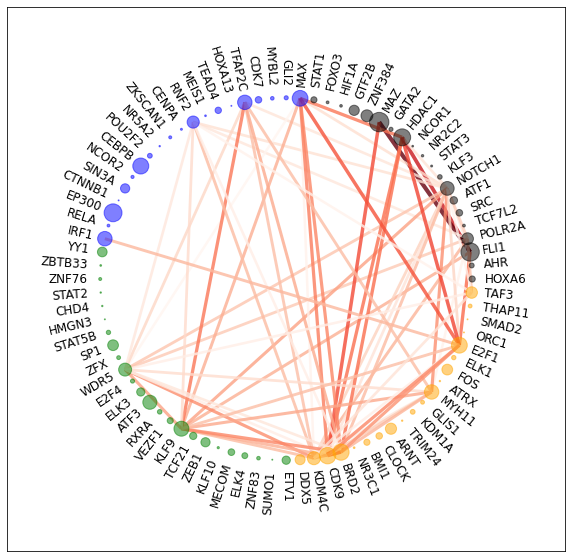

In [407]:
network = nx.from_pandas_edgelist(shared_targets, 'TF1', 'TF2', 'pval')

plt.figure(figsize = (10,10))
# Draw
pos = nx.circular_layout(network)

# Draw terminals 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = TF_annotation['TF'],
                       node_color = TF_annotation['color'], 
                       node_size = TF_annotation['n_targets'],
                       node_shape = 'o',
                       alpha = 0.5)

# Draw edges 
shared_targets_subset = shared_targets[shared_targets['pval'] < 1e-15].reset_index(drop=True)
print(shared_targets_subset.shape)
shared_targets_subset = shared_targets_subset[shared_targets_subset['proportion'] > 0.5].reset_index(drop=True)

selected_edges = [(shared_targets_subset.iloc[ix,:]['TF1'], shared_targets_subset.iloc[ix,:]['TF2']) 
                  for ix in shared_targets_subset.index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = selected_edges,
                       width= shared_targets_subset['proportion']*5, 
                       alpha=0.8, 
                       edge_color= shared_targets_subset['proportion'],
                       edge_cmap=plt.cm.Reds)

# Draw labels
theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items()} #gets degree of node positions
new_pos = {TF: np.array([x + np.cos(np.deg2rad(theta[TF]))/15, y + np.sin(np.deg2rad(theta[TF]))/15]) 
           for TF, (x,y) in pos.items()}
labels = nx.draw_networkx_labels(network,
                        new_pos,
                        font_size=12, 
                        ha='left')
# rotate the labels
for key,t in labels.items():
    if 90 < theta[key] or theta[key] < -90 :
        angle = 180 + theta[key]
        t.set_ha('right')
    else:
        angle = theta[key]
        t.set_ha('left')
    t.set_va('center')
    t.set_rotation(angle)
    t.set_rotation_mode('anchor')

plt.box("off")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.savefig(fig_dir + 'TF_target_sharing.png', dpi = 500, bbox_inches="tight")
plt.show()

In [189]:
# compare number of significant edges to random TFs
n_signif_edges = shared_targets[shared_targets['pval'] < 1e-100].shape[0]

# get TFs 
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
random.seed(202302)
random_TFs = random.sample(list(set(TF_targets['TF'])), 84)
TF_pairs = list(itertools.combinations(random_TFs, 2))

TF_targets = TF_targets[TF_targets['TF'].isin(random_TFs)]
n_DE_genes =  len(TF_targets['target'].unique()) # M = total number of objects

shared_targets_random = pd.DataFrame({'TF1': [], 'TF2': [], 'pval': [], 'proportion': []})

for TF_pair in tqdm(TF_pairs):
    time.sleep(0.01)
    TF1, TF2 = TF_pair

    targets_TF1 = set(TF_targets[TF_targets['TF'] == TF1]['target']) # n = total number of type 1 objects
    targets_TF2 = set(TF_targets[TF_targets['TF'] == TF2]['target']) # N = number of draws wo replacement
    shared = targets_TF1.intersection(targets_TF2)
    pval = stats.hypergeom.sf(len(shared), n_DE_genes, len(targets_TF1), len(targets_TF2))
    percent = len(shared) / len(targets_TF1.union(targets_TF2))
    row = pd.DataFrame({'TF1': [TF1], 'TF2': [TF2], 'pval': [pval], 'proportion': [percent]})
    shared_targets_random = pd.concat([shared_targets_random, row], ignore_index = True)

n_signif_edges_random = shared_targets_random[shared_targets_random['pval'] < 1e-100].shape[0]
print('Number of significant edges for bridge TFs: ' + str(n_signif_edges))
print('Number of significant edges for random TFs: ' + str(n_signif_edges_random))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3486/3486 [00:51<00:00, 67.36it/s]

Number of significant edges for bridge TFs: 421
Number of significant edges for random TFs: 412


In [163]:
TF_nets = TF_groups[['TF', 'net']].copy().drop_duplicates()
shared_per_group = shared_targets.merge(TF_nets.rename(columns={"TF": "TF1", "net": "group1"}), on = "TF1")
shared_per_group = shared_per_group.merge(TF_nets.rename(columns={"TF": "TF2", "net": "group2"}), on = "TF2")
shared_per_group['group'] = shared_per_group['group1'] + '_' + shared_per_group['group2']
shared_per_group = shared_per_group.groupby('group')['proportion'].mean()
shared_per_group

group
middle_net_middle_net    0.082618
middle_net_old_net       0.097973
old_net_old_net          0.113347
shared_middle_net        0.087820
shared_old_net           0.112105
shared_shared            0.096856
shared_young_net         0.094518
young_net_middle_net     0.081471
young_net_old_net        0.099058
young_net_young_net      0.085667
Name: proportion, dtype: float64

In [164]:
print('Average number of intersecting targets between group of net specific and shared bridge TFs: ')
print(np.mean([shared_per_group['shared_young_net'], shared_per_group['shared_middle_net'], shared_per_group['shared_old_net']]))

print('Average number of intersecting targets between groups of net specific bridge TFs: ')
print(np.mean([shared_per_group['young_net_middle_net'], shared_per_group['young_net_old_net'], shared_per_group['middle_net_old_net']]))

Average number of intersecting targets between group of net specific and shared bridge TFs: 
0.09814733435572837
Average number of intersecting targets between groups of net specific bridge TFs: 
0.09283415906772224
